In [1]:
from datetime import datetime
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import torch
from dotenv import load_dotenv
from PIL import Image
from tqdm import tqdm
from transformers import AutoConfig, AutoModelForCausalLM, AutoProcessor
load_dotenv()
from models.modeling_florence2 import Florence2ForConditionalGeneration
from models.processing_florence2 import Florence2Processor
device = torch.device("cpu")


/home/muddassir/miniforge3/envs/thesisenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/muddassir/miniforge3/envs/thesisenv/lib/python3.11/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:

# CHECKPOINT_PATH = "/home/docanalysis/florence2-training/models"
# CHECKPOINT_PATH="/home/docanalysis/florence2-training/runs/2025-04-16-16-08-12/checkpoint-116666"
# CHECKPOINT_PATH="/home/dll/Desktop/LayoutAnalysis/doclaynet_final/models"
CHECKPOINT_PATH="/home/muddassir/Desktop/LayoutAnalysis/server_data_second_exp/experiments/50epochs_new/checkpoint-10645"
print(CHECKPOINT_PATH)
config_f = AutoConfig.from_pretrained(
    CHECKPOINT_PATH, trust_remote_code=True
)
config_f.vision_config.model_type = "davit"
config_f.vision_config.in_chans = 3
model_f = (
    AutoModelForCausalLM.from_pretrained(
        CHECKPOINT_PATH,
        trust_remote_code=True,
        config=config_f,
        torch_dtype=torch.float16,
        ignore_mismatched_sizes=True,
    )
    .to(device)
    .eval()
)
processor_f = AutoProcessor.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)

/home/muddassir/Desktop/LayoutAnalysis/server_data_second_exp/experiments/50epochs_new/checkpoint-10645
use_pretrain_weight: load model from: /home/muddassir/Desktop/LayoutAnalysis/server_data_second_exp/models/word_embeddings.pt


In [3]:
id2label = {
    1: "Caption",
    2: "Footnote",
    3: "Formula",
    4: "ListItem",
    5: "PageFooter",
    6: "PageHeader",
    7: "Picture",
    8: "SectionHeader",
    9: "Table",
    10: "Text",
    11: "Title",
}
label2id = {v:k for k,v in id2label.items()}
prompts = ["<AO>",
            "<CAP>",
            "<FTN>",
            "<FRM>",
            "<LST>",
            "<PGF>",
            "<PGH>",
            "<PIC>",
            "<SHD>",
            "<TAB>",
            "<TXT>",
            "<TTL>",]

In [5]:
from datasets import load_from_disk
dataset = load_from_disk("/home/muddassir/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/val")

In [6]:
dataset[1].keys()

dict_keys(['image', 'category_ids', 'image_id', 'boxes', 'width', 'height', 'bbox_str', 'class_strs', 'ocr_words', 'ocr_boxes', 'input_ids', 'subword_bboxs'])

In [7]:
dataset[11]["class_strs"]

['PageHeader<loc_882><loc_28><loc_893><loc_35>',
 'SectionHeader<loc_39><loc_48><loc_242><loc_68><loc_474><loc_189><loc_630><loc_225><loc_256><loc_189><loc_381><loc_216><loc_39><loc_188><loc_172><loc_225>',
 'Picture<loc_37><loc_78><loc_245><loc_179><loc_253><loc_77><loc_462><loc_180><loc_472><loc_79><loc_680><loc_178><loc_690><loc_186><loc_897><loc_286><loc_690><loc_294><loc_898><loc_395><loc_327><loc_678><loc_534><loc_776><loc_180><loc_681><loc_315><loc_741><loc_319><loc_785><loc_388><loc_851><loc_613><loc_779><loc_706><loc_870>',
 'Text<loc_39><loc_228><loc_242><loc_284><loc_39><loc_296><loc_241><loc_539><loc_256><loc_218><loc_459><loc_500><loc_474><loc_228><loc_676><loc_490><loc_39><loc_681><loc_161><loc_748><loc_185><loc_789><loc_292><loc_826><loc_185><loc_838><loc_289><loc_865><loc_185><loc_877><loc_306><loc_934><loc_39><loc_799><loc_166><loc_895><loc_39><loc_907><loc_158><loc_944><loc_39><loc_956><loc_115><loc_973><loc_185><loc_946><loc_312><loc_973><loc_330><loc_916><loc_454><l

In [8]:
def run_example(task_prompt, example, max_new_tokens=4096, input_text: str = None):
    prompt = task_prompt
    if input_text is not None:
        prompt += input_text
    image = example["image"]
    input_ids = torch.tensor(example['input_ids'])
    bbox = torch.tensor(example['subword_bboxs'])
    inputs = processor_f(text=prompt,images=image, return_tensors="pt")
    inputs = {**inputs, "grid_data":[{"input_ids": input_ids, "bbox": bbox}]}
    generated_ids = model_f.generate(
        input_ids=inputs["input_ids"].to(device),
        pixel_values = inputs["pixel_values"].half().to(device),
        grid_data = inputs['grid_data'],
        max_new_tokens=max_new_tokens,
        early_stopping=False,
        do_sample=False,
        num_beams=3,)
    
    generated_text = processor_f.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor_f.post_process_generation(
        generated_text, task=task_prompt, image_size=(image.width, image.height)
    )
    return parsed_answer
def plot_bounding_boxes(image,bboxs, labels, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    for box, label in zip(bboxs, labels):
        rect = plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], linewidth=0.5, edgecolor='r', facecolor='g',alpha=0.3)
        #add class name
        ax.text(box[0], box[1],label, fontsize=12, color='red')
        ax.add_patch(rect)
    plt.show()

In [ ]:
Prompt = "<TXT>"
i = 6134
out = run_example(Prompt, dataset[i], input_text=None)
print(out)
plot_bounding_boxes(dataset[i]['image'], out[Prompt]['bboxes'], out[Prompt]['labels'])

In [10]:
out

{'<TXT>': {'bboxes': [[64.0625,
    100.96249389648438,
    239.33749389648438,
    144.0124969482422],
   [64.0625, 177.83749389648438, 469.9624938964844, 406.4124755859375],
   [64.0625, 408.4624938964844, 473.0374755859375, 606.2874755859375],
   [64.0625, 609.3624877929688, 464.8374938964844, 790.7874755859375],
   [520.1875, 607.3125, 926.0874633789062, 744.6624755859375],
   [520.1875, 408.4624938964844, 921.9874877929688, 606.2874755859375],
   [520.1875, 300.8374938964844, 911.7374877929688, 406.4124755859375],
   [520.1875, 177.83749389648438, 915.8374633789062, 297.7624816894531]],
  'labels': ['Text', 'Text', 'Text', 'Text', 'Text', 'Text', 'Text', 'Text']}}

In [20]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import time # Optional: for timing inference

# --- User Environment Setup (Ensure these are loaded/defined) ---
# These variables and functions MUST be defined in your execution environment
# before running the script below.

# from datasets import load_from_disk
# dataset = load_from_disk("/path/to/your/dataset/test") # Load your actual dataset

# id2label = { ... } # Your actual id2label mapping
# label2id = {v: k for k, v in id2label.items()} # Your actual label2id mapping

# model_f = ... # Your loaded model
# processor_f = ... # Your loaded processor
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# def run_example(task_prompt, example, max_new_tokens=128, input_text: str = None):
#     # --- Your actual run_example function as provided in the prompt ---
#     prompt = task_prompt
#     if input_text is not None:
#         prompt += input_text
#     image = example["image"]
#     # Ensure input_ids and subword_bboxs are handled correctly if needed by your processor/model
#     input_ids = torch.tensor(example.get('input_ids', [])) # Use .get for safety
#     bbox = torch.tensor(example.get('subword_bboxs', [])) # Use .get for safety

#     # Adapt processor call based on its actual signature
#     inputs = processor_f(text=prompt, images=image, return_tensors="pt")

#     # Add grid_data if your model expects it in this format
#     if input_ids.numel() > 0 and bbox.numel() > 0: # Check if tensors are not empty
#          inputs = {**inputs, "grid_data": [{"input_ids": input_ids, "bbox": bbox}]}
#     else:
#          # Handle cases where grid_data might not be needed or available
#          # Depending on your model, you might pass an empty dict or omit it
#          inputs = {**inputs} # Pass other inputs as needed

#     # Move inputs to the correct device
#     input_ids_dev = inputs["input_ids"].to(device)
#     pixel_values_dev = inputs["pixel_values"].half().to(device) # Use .half() if model expects fp16
#     grid_data_dev = inputs.get('grid_data') # Keep grid_data on CPU or move if necessary

#     # Prepare generation arguments
#     gen_kwargs = {
#         "input_ids": input_ids_dev,
#         "pixel_values": pixel_values_dev,
#         "max_new_tokens": max_new_tokens,
#         "early_stopping": False,
#         "do_sample": False,
#         "num_beams": 3,
#     }
#     # Only add grid_data to generation kwargs if it exists and is needed
#     if grid_data_dev:
#         gen_kwargs["grid_data"] = grid_data_dev

#     generated_ids = model_f.generate(**gen_kwargs)

#     generated_text = processor_f.batch_decode(generated_ids, skip_special_tokens=False)[0]
#     # print(f"Generated text for {task_prompt}: {generated_text}") # Optional debug print
#     parsed_answer = processor_f.post_process_generation(
#         generated_text, task=task_prompt, image_size=(image.width, image.height)
#     )
#     return parsed_answer
# --- End of User Environment Setup ---


# --- Evaluation Configuration ---
IOU_THRESHOLD = 0.5
# Limit the number of samples for testing (set to None to use the full dataset)
NUM_SAMPLES = None # e.g., 100
NUM_SAMPLES = 1000

# --- Helper Functions ---

def calculate_iou(boxA, boxB):
    """Calculates Intersection over Union (IoU) between two bounding boxes.
    Boxes are expected in [x_min, y_min, x_max, y_max] format.
    """
    # Determine the coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Compute the area of intersection
    interArea = max(0, xB - xA) * max(0, yB - yA)

    # Compute the area of both the prediction and ground-truth rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # Compute the union area
    # Add a small epsilon to avoid division by zero
    unionArea = boxAArea + boxBArea - interArea + 1e-6

    # Compute the IoU
    iou = interArea / unionArea
    return iou

def evaluate_layout_model(dataset, prompt_map, label_map_rev, iou_threshold=0.5, num_samples=None):
    """
    Evaluates the layout model on the provided dataset. Only prompts for classes
    present in the ground truth of each image.

    Args:
        dataset: The dataset object (Hugging Face dataset).
        prompt_map: Dictionary mapping prompt strings to label strings (e.g., "<TXT>": "Text").
        label_map_rev: Dictionary mapping label strings to prompt strings (e.g., "Text": "<TXT>").
        iou_threshold: The IoU threshold for matching predictions to ground truth.
        num_samples: Max number of samples to evaluate on (or None for all).

    Returns:
        A dictionary containing evaluation results (TP, FP, FN per class).
    """
    results = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0})
    total_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))
    processed_samples = 0

    iterator = tqdm(dataset.select(range(total_samples)), desc="Evaluating Samples") if num_samples else tqdm(dataset, desc="Evaluating Samples")

    for example in iterator:
        try:
            image = example['image']
            # Handle potential variations in box/category format
            gt_boxes_all = example.get('boxes', [])
            gt_category_ids = example.get('category_ids', [])

            # Ensure gt_boxes_all is a list of lists/tensors
            if not isinstance(gt_boxes_all, list) or (gt_boxes_all and not isinstance(gt_boxes_all[0], (list, torch.Tensor))):
                 print(f"Warning: Unexpected format for 'boxes' in sample. Skipping sample.")
                 # Optionally get sample ID if available: example.get('image_id', 'Unknown')
                 continue

            # Ensure gt_category_ids is a list of integers
            if not isinstance(gt_category_ids, list) or (gt_category_ids and not isinstance(gt_category_ids[0], int)):
                 # Handle nested list case like [[1, 2, 3]] if necessary
                 if isinstance(gt_category_ids, list) and len(gt_category_ids) == 1 and isinstance(gt_category_ids[0], list):
                     gt_category_ids = gt_category_ids[0]
                 elif not all(isinstance(item, int) for item in gt_category_ids):
                      print(f"Warning: Unexpected format for 'category_ids' in sample. Skipping sample.")
                      continue

             # Fix the AttributeError by removing .item() as category_ids are already ints
            gt_labels_present = set()
            gt_by_class = defaultdict(list)
            for idx, cat_id in enumerate(gt_category_ids):
                if cat_id in id2label:
                    label = id2label[cat_id]
                    gt_labels_present.add(label)
                    # Ensure box is a list of numbers, handle tensor or list
                    box = gt_boxes_all[idx]
                    gt_by_class[label].append(box.tolist() if isinstance(box, torch.Tensor) else box)
                else:
                    print(f"Warning: Unknown category_id {cat_id} found in sample. Skipping this label.")


            # Determine which prompts to run based on present GT labels
            prompts_for_this_image = [label_map_rev[label] for label in gt_labels_present if label in label_map_rev]

            if not prompts_for_this_image:
                # This can happen if the image has labels not in our label_map_rev
                # Or if the image genuinely has no labels we are evaluating
                # print(f"No relevant prompts for image based on GT labels: {gt_labels_present}. Skipping inference.")
                processed_samples+=1
                continue # Skip to next image if no relevant classes are present

            # --- Run Inference ONLY for relevant prompts ---
            for prompt in prompts_for_this_image:
                class_label = prompt_map.get(prompt) # Get the corresponding label string
                if not class_label: # Should not happen if maps are consistent
                    print(f"Error: No label found for prompt '{prompt}'. Check mappings.")
                    continue

                # --- Run Inference ---
                try:
                    start_time = time.time()
                    # Prepare the 'example' dict for run_example, ensuring necessary fields are present
                    inference_example = {
                        'image': image,
                        # Pass other fields if your run_example requires them explicitly
                         'input_ids': example.get('input_ids'),
                         'subword_bboxs': example.get('subword_bboxs')
                    }
                    inference_output = run_example(
                        task_prompt=prompt,
                        example=inference_example
                        # max_new_tokens=128 # Add other args if needed
                    )
                    # print(f"Inference time for {prompt}: {time.time() - start_time:.2f}s") # Optional

                    # Extract predictions for the *prompted* class
                    pred_data = inference_output.get(prompt, {'bboxes': [], 'labels': []})
                    pred_boxes = pred_data.get('bboxes', [])
                    pred_labels = pred_data.get('labels', [])

                    # Filter predictions to only those the model *labelled* as the target class
                    filtered_pred_boxes = [
                        box for box, lbl in zip(pred_boxes, pred_labels) if lbl == class_label
                    ]

                except Exception as e:
                    print(f"Error during inference for sample, prompt {prompt}: {e}")
                    # Optionally log sample ID here if available
                    filtered_pred_boxes = [] # Assume no predictions if error occurs


                # --- Match Predictions to Ground Truth for the current class ---
                gt_boxes_cls = gt_by_class[class_label]
                num_gt = len(gt_boxes_cls)
                num_pred = len(filtered_pred_boxes)

                if num_gt == 0 and num_pred == 0:
                    # This case should ideally not be reached due to outer loop logic, but check anyway
                    continue

                gt_matched = [False] * num_gt
                pred_matched = [False] * num_pred
                tp = 0

                if num_pred > 0 and num_gt > 0:
                    iou_matrix = np.zeros((num_pred, num_gt))
                    for p_idx, p_box in enumerate(filtered_pred_boxes):
                         # Ensure p_box format is correct (list of numbers)
                        if not isinstance(p_box, list) or len(p_box) != 4:
                             print(f"Warning: Invalid prediction box format: {p_box}. Skipping.")
                             continue
                        for g_idx, g_box in enumerate(gt_boxes_cls):
                             # Ensure g_box format is correct
                            if not isinstance(g_box, list) or len(g_box) != 4:
                                 print(f"Warning: Invalid ground truth box format: {g_box}. Skipping.")
                                 continue
                            iou_matrix[p_idx, g_idx] = calculate_iou(p_box, g_box)

                    # Greedy matching based on highest IoU first
                    potential_matches = np.argwhere(iou_matrix >= iou_threshold)
                    # Get IoU values corresponding to the potential matches
                    if potential_matches.size > 0:
                        iou_values = iou_matrix[potential_matches[:, 0], potential_matches[:, 1]]
                        # Sort indices by IoU value in descending order
                        sorted_indices = np.argsort(iou_values)[::-1]

                        for idx in sorted_indices:
                            p_idx, g_idx = potential_matches[idx]
                            # Check if either the prediction or the ground truth is already matched
                            if not pred_matched[p_idx] and not gt_matched[g_idx]:
                                tp += 1
                                pred_matched[p_idx] = True
                                gt_matched[g_idx] = True
                    # else: No matches found above threshold

                # Calculate FP (unmatched predictions) and FN (unmatched ground truths)
                fp = num_pred - sum(pred_matched)
                fn = num_gt - sum(gt_matched)

                # Accumulate results for this class
                results[class_label]['tp'] += tp
                results[class_label]['fp'] += fp
                results[class_label]['fn'] += fn

            processed_samples += 1

        except Exception as e:
            print(f"Error processing sample: {e}")
            # Optionally log sample ID
            continue # Move to the next sample

    print(f"\nProcessed {processed_samples} samples.")
    if processed_samples == 0:
         print("Warning: No samples were processed successfully.")

    return results

def calculate_metrics(results):
    """Calculates Precision, Recall, F1 from TP, FP, FN counts."""
    metrics = {}
    all_tp, all_fp, all_fn = 0, 0, 0

    # Filter out classes with no TP, FP, or FN (if any somehow occurred)
    valid_labels = [label for label, counts in results.items() if counts['tp'] > 0 or counts['fp'] > 0 or counts['fn'] > 0]

    if not valid_labels:
        print("\nNo valid results found to calculate metrics.")
        return {}

    print("\n--- Per-Class Metrics ---")
    class_precisions = []
    class_recalls = []
    class_f1s = []

    for label in sorted(valid_labels): # Sort for consistent output
        counts = results[label]
        tp = counts['tp']
        fp = counts['fp']
        fn = counts['fn']
        all_tp += tp
        all_fp += fp
        all_fn += fn

        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        metrics[label] = {'precision': precision, 'recall': recall, 'f1': f1, 'tp': tp, 'fp': fp, 'fn': fn}
        class_precisions.append(precision)
        class_recalls.append(recall)
        class_f1s.append(f1) # Store F1 for macro calculation

        print(f"{label}:")
        print(f"  TP: {tp}, FP: {fp}, FN: {fn}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")

    # --- Overall Metrics (Micro Average) ---
    micro_precision = all_tp / (all_tp + all_fp) if (all_tp + all_fp) > 0 else 0.0
    micro_recall = all_tp / (all_tp + all_fn) if (all_tp + all_fn) > 0 else 0.0
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0.0

    metrics['overall_micro'] = {'precision': micro_precision, 'recall': micro_recall, 'f1': micro_f1, 'tp': all_tp, 'fp': all_fp, 'fn': all_fn}
    print("\n--- Overall Metrics (Micro Average) ---")
    print(f"Total TP: {all_tp}, Total FP: {all_fp}, Total FN: {all_fn}")
    print(f"Precision: {micro_precision:.4f}")
    print(f"Recall:    {micro_recall:.4f}")
    print(f"F1-Score:  {micro_f1:.4f}")

    # --- Overall Metrics (Macro Average) ---
    num_classes_evaluated = len(valid_labels)
    if num_classes_evaluated > 0:
        macro_precision = sum(class_precisions) / num_classes_evaluated
        macro_recall = sum(class_recalls) / num_classes_evaluated
        # Calculate Macro F1 based on the macro P and R for better accuracy
        if (macro_precision + macro_recall) > 0:
            macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)
        else:
            macro_f1 = 0.0
        # Naive macro F1 (average of per-class F1s) can also be reported if desired:
        # naive_macro_f1 = sum(class_f1s) / num_classes_evaluated
    else:
        macro_precision, macro_recall, macro_f1 = 0.0, 0.0, 0.0

    metrics['overall_macro'] = {'precision': macro_precision, 'recall': macro_recall, 'f1': macro_f1}
    print("\n--- Overall Metrics (Macro Average) ---")
    print(f"Averaged over {num_classes_evaluated} classes: {', '.join(sorted(valid_labels))}")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall:    {macro_recall:.4f}")
    print(f"F1-Score:  {macro_f1:.4f}")


    return metrics

# --- Main Execution ---
if __name__ == "__main__":
    # --- Define Mappings (Essential!) ---
    # Ensure these mappings are complete and correct for your model/dataset
    # You need BOTH prompt->label and label->prompt

    # Example: Assume id2label is defined
    # Example: Assume a function get_prompt_for_label(label) exists or define map manually
    # This needs to align with your `prompts` list and `id2label`
    prompt_to_label_map = {
        "<CAP>": "Caption", "<FTN>": "Footnote", "<FRM>": "Formula", "<LST>": "ListItem",
        "<PGF>": "PageFooter", "<PGH>": "PageHeader", "<PIC>": "Picture", "<SHD>": "SectionHeader",
        "<TAB>": "Table", "<TXT>": "Text", "<TTL>": "Title",
        # Add any other prompts your model uses
    }
    # Automatically filter based on labels actually in your dataset's id2label
    # and create the reverse mapping
    filtered_prompt_to_label = {p: l for p, l in prompt_to_label_map.items() if l in label2id}
    label_to_prompt_map = {v: k for k, v in filtered_prompt_to_label.items()}

    dataset = load_from_disk("/home/dll/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/test")

    print(f"Using {len(filtered_prompt_to_label)} mappings based on id2label:")
    # print(filtered_prompt_to_label) # Uncomment to verify

    if not filtered_prompt_to_label:
        print("Error: No valid prompt-to-label mappings found. Check id2label and prompt_to_label_map.")
    else:
        # Run the evaluation
        # Ensure dataset is loaded and available here
        # Pass the mappings to the evaluation function
        evaluation_results = evaluate_layout_model(
            dataset=dataset, # Pass the raw dataset, format handling is inside
            prompt_map=filtered_prompt_to_label,
            label_map_rev=label_to_prompt_map,
            iou_threshold=IOU_THRESHOLD,
            num_samples=NUM_SAMPLES
        )

        # Calculate and print metrics
        if evaluation_results:
            final_metrics = calculate_metrics(evaluation_results)
        else:
            print("Evaluation did not produce results.")

        print("\nEvaluation Complete.")

# --- Discussion on Other Metrics (Remains the same) ---
# mAP, Localization Accuracy (IoU), Speed, Robustness, etc.
# See previous response for details.

Using 11 mappings based on id2label:


Evaluating Samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Evaluating Samples:   4%|▍         | 39/1000 [00:21<08:40,  1.85it/s]


KeyboardInterrupt: 

In [21]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import time # Optional: for timing inference




# --- Evaluation Configuration ---
IOU_THRESHOLD = 0.5 # IoU threshold for TP/FP/FN determination
# Limit the number of samples for testing (set to None to use the full dataset)
NUM_SAMPLES = None # e.g., 100

# --- Helper Functions ---

def calculate_iou(boxA, boxB):
    """Calculates Intersection over Union (IoU) between two bounding boxes.
    Boxes are expected in [x_min, y_min, x_max, y_max] format.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea + 1e-6 # Epsilon for stability
    iou = interArea / unionArea
    return iou

def evaluate_layout_model(dataset, prompt_map, label_map_rev, iou_threshold=0.5, num_samples=None):
    """
    Evaluates the layout model, calculating TP, FP, FN, and sum of IoUs for TPs.
    Only prompts for classes present in the ground truth of each image.

    Args:
        dataset: The dataset object (Hugging Face dataset).
        prompt_map: Dictionary mapping prompt strings to label strings (e.g., "<TXT>": "Text").
        label_map_rev: Dictionary mapping label strings to prompt strings (e.g., "Text": "<TXT>").
        iou_threshold: The IoU threshold for matching predictions to ground truth.
        num_samples: Max number of samples to evaluate on (or None for all).

    Returns:
        A tuple: (results, all_tp_iou_sum)
          - results: Dictionary containing evaluation results per class
                     (TP, FP, FN, tp_iou_sum).
          - all_tp_iou_sum: Float, the total sum of IoU values for all True Positives across all classes.
    """
    # Initialize results dict, adding 'tp_iou_sum'
    results = defaultdict(lambda: {'tp': 0, 'fp': 0, 'fn': 0, 'tp_iou_sum': 0.0})
    all_tp_iou_sum = 0.0 # Accumulator for overall average IoU calculation
    total_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))
    processed_samples = 0

    iterator = tqdm(dataset.select(range(total_samples)), desc="Evaluating Samples") if num_samples else tqdm(dataset, desc="Evaluating Samples")

    for example in iterator:
        try:
            image = example['image']
            gt_boxes_all = example.get('boxes', [])
            gt_category_ids = example.get('category_ids', [])

            # --- Data Validation and Preparation ---
            if not isinstance(gt_boxes_all, list) or (gt_boxes_all and not isinstance(gt_boxes_all[0], (list, torch.Tensor))):
                 print(f"Warning: Unexpected format for 'boxes' in sample. Skipping sample.")
                 continue
            if not isinstance(gt_category_ids, list): # Allow empty list
                gt_category_ids = []
            elif gt_category_ids and not isinstance(gt_category_ids[0], int):
                 if len(gt_category_ids) == 1 and isinstance(gt_category_ids[0], list):
                     gt_category_ids = gt_category_ids[0] # Handle nested list case
                 elif not all(isinstance(item, int) for item in gt_category_ids):
                      print(f"Warning: Unexpected format for 'category_ids' in sample. Skipping sample.")
                      continue

            gt_labels_present = set()
            gt_by_class = defaultdict(list)
            for idx, cat_id in enumerate(gt_category_ids):
                if cat_id in id2label:
                    label = id2label[cat_id]
                    gt_labels_present.add(label)
                    box = gt_boxes_all[idx]
                    gt_by_class[label].append(box.tolist() if isinstance(box, torch.Tensor) else box)
                # else: Silently ignore unknown category IDs

            prompts_for_this_image = [label_map_rev[label] for label in gt_labels_present if label in label_map_rev]

            if not prompts_for_this_image:
                processed_samples+=1
                continue
            # --- End Data Validation ---


            # --- Run Inference ONLY for relevant prompts ---
            for prompt in prompts_for_this_image:
                class_label = prompt_map.get(prompt)
                if not class_label: continue

                # --- Run Inference ---
                try:
                    # start_time = time.time() # Optional timing
                    inference_example = {'image': image, 'input_ids': example.get('input_ids'), 'subword_bboxs': example.get('subword_bboxs')}
                    inference_output = run_example(task_prompt=prompt, example=inference_example)
                    # print(f"Inference time for {prompt}: {time.time() - start_time:.2f}s") # Optional

                    pred_data = inference_output.get(prompt, {'bboxes': [], 'labels': []})
                    pred_boxes = pred_data.get('bboxes', [])
                    pred_labels = pred_data.get('labels', [])
                    filtered_pred_boxes = [box for box, lbl in zip(pred_boxes, pred_labels) if lbl == class_label]
                except Exception as e:
                    print(f"Error during inference for sample, prompt {prompt}: {e}")
                    filtered_pred_boxes = []
                # --- End Inference ---


                # --- Match Predictions to Ground Truth ---
                gt_boxes_cls = gt_by_class[class_label]
                num_gt = len(gt_boxes_cls)
                num_pred = len(filtered_pred_boxes)

                if num_gt == 0 and num_pred == 0: continue

                gt_matched = [False] * num_gt
                pred_matched = [False] * num_pred
                tp = 0
                current_tp_iou_sum = 0.0 # Sum IoUs for TPs *in this image/class*

                if num_pred > 0 and num_gt > 0:
                    iou_matrix = np.zeros((num_pred, num_gt))
                    valid_preds = [] # Store indices of valid predictions
                    for p_idx, p_box in enumerate(filtered_pred_boxes):
                        if not isinstance(p_box, list) or len(p_box) != 4:
                            print(f"Warning: Invalid prediction box format skipped: {p_box}")
                            continue
                        valid_preds.append(p_idx) # Track valid prediction index
                        valid_gt = [] # Store indices of valid ground truths for this pred
                        for g_idx, g_box in enumerate(gt_boxes_cls):
                            if not isinstance(g_box, list) or len(g_box) != 4:
                                # This check might be redundant if GT is clean, but safe
                                print(f"Warning: Invalid ground truth box format skipped: {g_box}")
                                continue
                            valid_gt.append(g_idx) # Track valid GT index
                            # Calculate IoU only between valid boxes
                            iou_matrix[p_idx, g_idx] = calculate_iou(p_box, g_box)

                    # Ensure we only consider valid boxes in matching
                    if valid_preds and valid_gt:
                         # Consider only the submatrix of valid preds/GTs for matching
                         valid_iou_matrix = iou_matrix[np.ix_(valid_preds, valid_gt)]
                         potential_matches = np.argwhere(valid_iou_matrix >= iou_threshold)

                         if potential_matches.size > 0:
                            # Map indices back to original filtered_pred_boxes and gt_boxes_cls
                            original_p_indices = [valid_preds[i] for i in potential_matches[:, 0]]
                            original_g_indices = [valid_gt[i] for i in potential_matches[:, 1]]

                            iou_values = valid_iou_matrix[potential_matches[:, 0], potential_matches[:, 1]]
                            sorted_indices = np.argsort(iou_values)[::-1] # Sort descending

                            for idx in sorted_indices:
                                p_idx = original_p_indices[idx] # Original index in filtered_pred_boxes
                                g_idx = original_g_indices[idx] # Original index in gt_boxes_cls

                                # Check if boxes (by original index) are already matched
                                if not pred_matched[p_idx] and not gt_matched[g_idx]:
                                    tp += 1
                                    pred_matched[p_idx] = True
                                    gt_matched[g_idx] = True
                                    # Accumulate IoU for this specific TP match
                                    iou_value = iou_matrix[p_idx, g_idx] # Get the actual IoU
                                    current_tp_iou_sum += iou_value


                # Calculate FP, FN for this class/image
                fp = sum(1 for p_idx, p_box in enumerate(filtered_pred_boxes) if not pred_matched[p_idx] and isinstance(p_box, list) and len(p_box) == 4) # Count only valid unmatched preds as FP
                fn = num_gt - sum(gt_matched)

                # Accumulate results for the class across all images
                results[class_label]['tp'] += tp
                results[class_label]['fp'] += fp
                results[class_label]['fn'] += fn
                results[class_label]['tp_iou_sum'] += current_tp_iou_sum # Add sum for this image/class

            processed_samples += 1 # Increment after successfully processing all prompts for the image

        except Exception as e:
            print(f"Fatal error processing sample (Index maybe unreliable if dataset shuffled): {e}")
            # Optionally log sample ID if available: example.get('image_id', 'Unknown')
            continue # Move to the next sample

    # --- Calculate total IoU sum after processing all samples ---
    # Sum up the per-class IoU sums collected in the results dict
    all_tp_iou_sum = sum(counts.get('tp_iou_sum', 0.0) for counts in results.values())

    print(f"\nProcessed {processed_samples} samples.")
    if processed_samples == 0:
         print("Warning: No samples were processed successfully.")

    return results, all_tp_iou_sum # Return both results dict and total IoU sum

def calculate_metrics(results, all_tp_iou_sum):
    """Calculates Precision, Recall, F1, and Avg IoU from TP, FP, FN counts."""
    metrics = {}
    all_tp, all_fp, all_fn = 0, 0, 0

    valid_labels = [label for label, counts in results.items() if counts['tp'] > 0 or counts['fp'] > 0 or counts['fn'] > 0]

    if not valid_labels:
        print("\nNo valid results found to calculate metrics.")
        return {}

    print("\n--- Per-Class Metrics ---")
    class_precisions = []
    class_recalls = []
    class_f1s = []
    class_avg_ious = [] # To calculate overall average IoU correctly later if needed

    for label in sorted(valid_labels): # Sort for consistent output
        counts = results[label]
        tp = counts['tp']
        fp = counts['fp']
        fn = counts['fn']
        tp_iou_sum = counts.get('tp_iou_sum', 0.0) # Get the sum of IoUs for TPs

        all_tp += tp
        all_fp += fp
        all_fn += fn

        # Calculate P, R, F1
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        # Calculate Average IoU for TPs of this class
        avg_iou_class = tp_iou_sum / tp if tp > 0 else 0.0
        if tp > 0:
            class_avg_ious.append(avg_iou_class) # Store for potential macro avg IoU

        metrics[label] = {
            'precision': precision, 'recall': recall, 'f1': f1,
            'avg_iou': avg_iou_class, # Add avg IoU here
            'tp': tp, 'fp': fp, 'fn': fn
        }
        class_precisions.append(precision)
        class_recalls.append(recall)
        class_f1s.append(f1)

        # Print metrics for the class
        print(f"{label}:")
        print(f"  TP: {tp}, FP: {fp}, FN: {fn}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall:    {recall:.4f}")
        print(f"  F1-Score:  {f1:.4f}")
        print(f"  Avg TP IoU:{avg_iou_class:.4f}") # Print avg IoU

    # --- Overall Metrics (Micro Average) ---
    # Micro P, R, F1 are calculated based on total TP, FP, FN
    micro_precision = all_tp / (all_tp + all_fp) if (all_tp + all_fp) > 0 else 0.0
    micro_recall = all_tp / (all_tp + all_fn) if (all_tp + all_fn) > 0 else 0.0
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0.0

    # Overall Average IoU is calculated based on total sum of TP IoUs and total TPs
    overall_avg_iou = all_tp_iou_sum / all_tp if all_tp > 0 else 0.0

    metrics['overall_micro'] = {
        'precision': micro_precision, 'recall': micro_recall, 'f1': micro_f1,
        'avg_iou': overall_avg_iou, # Add overall avg IoU here
        'tp': all_tp, 'fp': all_fp, 'fn': all_fn
    }
    print("\n--- Overall Metrics (Micro Average) ---")
    print(f"Total TP: {all_tp}, Total FP: {all_fp}, Total FN: {all_fn}")
    print(f"Precision: {micro_precision:.4f}")
    print(f"Recall:    {micro_recall:.4f}")
    print(f"F1-Score:  {micro_f1:.4f}")
    print(f"Avg TP IoU:{overall_avg_iou:.4f}") # Print overall avg IoU

    # --- Overall Metrics (Macro Average) ---
    num_classes_evaluated = len(valid_labels)
    if num_classes_evaluated > 0:
        macro_precision = sum(class_precisions) / num_classes_evaluated
        macro_recall = sum(class_recalls) / num_classes_evaluated
        if (macro_precision + macro_recall) > 0:
            macro_f1 = 2 * (macro_precision * macro_recall) / (macro_precision + macro_recall)
        else:
            macro_f1 = 0.0
        # Optional: Macro Average IoU (average of per-class average IoUs)
        # macro_avg_iou = sum(class_avg_ious) / len(class_avg_ious) if class_avg_ious else 0.0
    else:
        macro_precision, macro_recall, macro_f1 = 0.0, 0.0, 0.0
        # macro_avg_iou = 0.0

    metrics['overall_macro'] = {'precision': macro_precision, 'recall': macro_recall, 'f1': macro_f1}
    print("\n--- Overall Metrics (Macro Average) ---")
    print(f"Averaged over {num_classes_evaluated} classes: {', '.join(sorted(valid_labels))}")
    print(f"Precision: {macro_precision:.4f}")
    print(f"Recall:    {macro_recall:.4f}")
    print(f"F1-Score:  {macro_f1:.4f}")
    # print(f"Avg TP IoU:{macro_avg_iou:.4f}") # Optional: print macro avg IoU

    return metrics

# --- Main Execution ---
if __name__ == "__main__":
    # --- Define Mappings (Essential!) ---
    # Ensure id2label is defined and available from your setup
    # Ensure your prompts align with the desired labels

    # prompt_to_label_map = {
    #     "<CAP>": "Caption", "<FTN>": "Footnote", "<FRM>": "Formula", "<LST>": "ListItem",
    #     "<PGF>": "PageFooter", "<PGH>": "PageHeader", "<PIC>": "Picture", "<SHD>": "SectionHeader",
    #     "<TAB>": "Table", "<TXT>": "Text", "<TTL>": "Title",
    #     # Add any other prompts your model uses
    # }



    prompt_to_label_map = {
    "<CAP>":"Caption",
    "<FN>": "Footnote",  # Changed from <FTN>
    "<FRM>":"Formula",
    "<LST>":"ListItem",
    "<PGF>":"PageFooter",
    "<PGH>":"PageHeader",
    "<PIC>":"Picture",
    "<SHD>":"SectionHeader",
    "<TAB>":"Table",
    "<TXT>":"Text",
    "<TTL>":"Title",
}

    # Filter mappings based on labels actually in id2label
    # Check if id2label is defined
    if 'id2label' not in globals():
         print("Error: 'id2label' mapping is not defined in the environment. Please load or define it.")
         # Exit or raise error
         import sys
         sys.exit(1)

    filtered_prompt_to_label = {p: l for p, l in prompt_to_label_map.items() if l in id2label.values()}
    label_to_prompt_map = {v: k for k, v in filtered_prompt_to_label.items()}

    dataset = load_from_disk("/home/dll/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/test")
    import random
    num_samples = 100

# Randomly select indices
    random_indices = random.sample(range(len(dataset)), num_samples)

# Get the samples
    dataset = dataset.select(random_indices)

    print(f"Using {len(filtered_prompt_to_label)} mappings based on id2label.")

    if not filtered_prompt_to_label:
        print("Error: No valid prompt-to-label mappings found. Check id2label and prompt_to_label_map.")
    else:
        # --- Ensure dataset is loaded ---
        if 'dataset' not in globals():
            print("Error: 'dataset' is not defined. Please load your dataset.")
            import sys
            sys.exit(1)

        # Run the evaluation - it now returns two values
        evaluation_results, total_tp_iou_sum = evaluate_layout_model(
            dataset=dataset, # Pass the raw dataset
            prompt_map=filtered_prompt_to_label,
            label_map_rev=label_to_prompt_map,
            iou_threshold=IOU_THRESHOLD,
            num_samples=NUM_SAMPLES
        )

        # Calculate and print metrics - pass the total IoU sum
        if evaluation_results:
            final_metrics = calculate_metrics(evaluation_results, total_tp_iou_sum)
        else:
            print("Evaluation did not produce results.")

        print("\nEvaluation Complete.")

Using 11 mappings based on id2label.


Evaluating Samples: 100%|██████████| 100/100 [00:52<00:00,  1.90it/s]


Processed 100 samples.

--- Per-Class Metrics ---
Caption:
  TP: 29, FP: 6, FN: 2
  Precision: 0.8286
  Recall:    0.9355
  F1-Score:  0.8788
  Avg TP IoU:0.8767
Footnote:
  TP: 7, FP: 0, FN: 5
  Precision: 1.0000
  Recall:    0.5833
  F1-Score:  0.7368
  Avg TP IoU:0.8970
Formula:
  TP: 24, FP: 9, FN: 8
  Precision: 0.7273
  Recall:    0.7500
  F1-Score:  0.7385
  Avg TP IoU:0.7563
ListItem:
  TP: 224, FP: 23, FN: 26
  Precision: 0.9069
  Recall:    0.8960
  F1-Score:  0.9014
  Avg TP IoU:0.9008
PageFooter:
  TP: 65, FP: 13, FN: 13
  Precision: 0.8333
  Recall:    0.8333
  F1-Score:  0.8333
  Avg TP IoU:0.7746
PageHeader:
  TP: 52, FP: 14, FN: 14
  Precision: 0.7879
  Recall:    0.7879
  F1-Score:  0.7879
  Avg TP IoU:0.8356
Picture:
  TP: 59, FP: 7, FN: 7
  Precision: 0.8939
  Recall:    0.8939
  F1-Score:  0.8939
  Avg TP IoU:0.9393
SectionHeader:
  TP: 144, FP: 21, FN: 38
  Precision: 0.8727
  Recall:    0.7912
  F1-Score:  0.8300
  Avg TP IoU:0.8493
Table:
  TP: 62, FP: 3, FN: 3


# Modified Cl

In [5]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import time
from sklearn.metrics import precision_recall_curve, average_precision_score
from datasets import load_from_disk

# --- Evaluation Configuration ---
IOU_THRESHOLD = 0.5  # IoU threshold for TP/FP/FN determination
NUM_SAMPLES = None  # e.g., 100
CONFIDENCE_SCORE = 1.0  # Constant confidence score since model doesn't output confidence

# --- Helper Functions ---

def calculate_iou(boxA, boxB):
    """Calculates Intersection over Union (IoU) between two bounding boxes.
    Boxes are expected in [x_min, y_min, x_max, y_max] format.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea + 1e-6  # Epsilon for stability
    iou = interArea / unionArea
    return iou

def calculate_ap_from_pr_curve(precision, recall):
    """
    Calculate Average Precision (AP) using the precision-recall curve.
    Uses the 11-point interpolation method (PASCAL VOC style).
    """
    if len(precision) == 0 or len(recall) == 0:
        return 0.0
    
    # Sort by recall
    sorted_indices = np.argsort(recall)
    recall = recall[sorted_indices]
    precision = precision[sorted_indices]
    
    # Add endpoints
    recall = np.concatenate(([0.0], recall, [1.0]))
    precision = np.concatenate(([0.0], precision, [0.0]))
    
    # Compute the precision envelope
    for i in range(len(precision) - 2, -1, -1):
        precision[i] = max(precision[i], precision[i + 1])
    
    # Calculate AP using 11-point interpolation
    ap = 0.0
    for t in np.arange(0, 1.1, 0.1):
        # Find the maximum precision for recall >= t
        p = np.max(precision[recall >= t]) if np.any(recall >= t) else 0.0
        ap += p / 11.0
    
    return ap

def evaluate_layout_model_for_ap(dataset, prompt_map, label_map_rev, iou_threshold=0.5, num_samples=None):
    """
    Evaluates the layout model for AP calculation.
    Returns detection results for each class with confidence scores and match status.
    """
    # Store detection results for each class
    class_detections = defaultdict(list)  # {class_name: [{'confidence': float, 'matched': bool, 'iou': float}]}
    class_gt_counts = defaultdict(int)  # {class_name: total_gt_count}
    
    total_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))
    processed_samples = 0

    iterator = tqdm(dataset.select(range(total_samples)), desc="Evaluating Samples") if num_samples else tqdm(dataset, desc="Evaluating Samples")

    for example in iterator:
        try:
            image = example['image']
            gt_boxes_all = example.get('boxes', [])
            gt_category_ids = example.get('category_ids', [])

            # --- Data Validation and Preparation ---
            if not isinstance(gt_boxes_all, list) or (gt_boxes_all and not isinstance(gt_boxes_all[0], (list, torch.Tensor))):
                print(f"Warning: Unexpected format for 'boxes' in sample. Skipping sample.")
                continue
            if not isinstance(gt_category_ids, list):
                gt_category_ids = []
            elif gt_category_ids and not isinstance(gt_category_ids[0], int):
                if len(gt_category_ids) == 1 and isinstance(gt_category_ids[0], list):
                    gt_category_ids = gt_category_ids[0]
                elif not all(isinstance(item, int) for item in gt_category_ids):
                    print(f"Warning: Unexpected format for 'category_ids' in sample. Skipping sample.")
                    continue

            gt_labels_present = set()
            gt_by_class = defaultdict(list)
            for idx, cat_id in enumerate(gt_category_ids):
                if cat_id in id2label:
                    label = id2label[cat_id]
                    gt_labels_present.add(label)
                    box = gt_boxes_all[idx]
                    gt_by_class[label].append(box.tolist() if isinstance(box, torch.Tensor) else box)
                    class_gt_counts[label] += 1

            prompts_for_this_image = [label_map_rev[label] for label in gt_labels_present if label in label_map_rev]

            if not prompts_for_this_image:
                processed_samples += 1
                continue

            # --- Run Inference for relevant prompts ---
            for prompt in prompts_for_this_image:
                class_label = prompt_map.get(prompt)
                if not class_label:
                    continue

                # --- Run Inference ---
                try:
                    inference_example = {'image': image, 'input_ids': example.get('input_ids'), 'subword_bboxs': example.get('subword_bboxs')}
                    inference_output = run_example(task_prompt=prompt, example=inference_example)

                    pred_data = inference_output.get(prompt, {'bboxes': [], 'labels': []})
                    pred_boxes = pred_data.get('bboxes', [])
                    pred_labels = pred_data.get('labels', [])
                    filtered_pred_boxes = [box for box, lbl in zip(pred_boxes, pred_labels) if lbl == class_label]
                except Exception as e:
                    print(f"Error during inference for sample, prompt {prompt}: {e}")
                    filtered_pred_boxes = []

                # --- Match Predictions to Ground Truth ---
                gt_boxes_cls = gt_by_class[class_label]
                num_gt = len(gt_boxes_cls)
                num_pred = len(filtered_pred_boxes)

                if num_pred == 0:
                    continue

                gt_matched = [False] * num_gt
                
                # For each prediction, find the best matching ground truth
                for pred_box in filtered_pred_boxes:
                    if not isinstance(pred_box, list) or len(pred_box) != 4:
                        print(f"Warning: Invalid prediction box format skipped: {pred_box}")
                        class_detections[class_label].append({
                            'confidence': CONFIDENCE_SCORE,
                            'matched': False,
                            'iou': 0.0
                        })
                        continue
                    
                    best_iou = 0.0
                    best_gt_idx = -1
                    
                    # Find the best matching ground truth box
                    for gt_idx, gt_box in enumerate(gt_boxes_cls):
                        if not isinstance(gt_box, list) or len(gt_box) != 4:
                            continue
                        
                        iou = calculate_iou(pred_box, gt_box)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx
                    
                    # Determine if this prediction is a match
                    is_match = False
                    if best_gt_idx != -1 and best_iou >= iou_threshold and not gt_matched[best_gt_idx]:
                        is_match = True
                        gt_matched[best_gt_idx] = True
                    
                    class_detections[class_label].append({
                        'confidence': CONFIDENCE_SCORE,
                        'matched': is_match,
                        'iou': best_iou
                    })

            processed_samples += 1

        except Exception as e:
            print(f"Fatal error processing sample: {e}")
            continue

    print(f"\nProcessed {processed_samples} samples.")
    return class_detections, class_gt_counts

def calculate_ap_and_map(class_detections, class_gt_counts, plot_curves=True):
    """
    Calculate Average Precision (AP) for each class and mean Average Precision (mAP).
    """
    class_aps = {}
    
    if plot_curves:
        plt.figure(figsize=(15, 10))
        num_classes = len(class_detections)
        cols = 3
        rows = (num_classes + cols - 1) // cols
    
    for i, (class_name, detections) in enumerate(sorted(class_detections.items())):
        if len(detections) == 0:
            class_aps[class_name] = 0.0
            print(f"{class_name}: AP = 0.0000 (no detections)")
            continue
        
        # Sort detections by confidence (descending)
        detections_sorted = sorted(detections, key=lambda x: x['confidence'], reverse=True)
        
        # Calculate precision and recall at each threshold
        tp_cumsum = 0
        fp_cumsum = 0
        precisions = []
        recalls = []
        
        total_gt = class_gt_counts[class_name]
        
        for detection in detections_sorted:
            if detection['matched']:
                tp_cumsum += 1
            else:
                fp_cumsum += 1
            
            precision = tp_cumsum / (tp_cumsum + fp_cumsum) if (tp_cumsum + fp_cumsum) > 0 else 0.0
            recall = tp_cumsum / total_gt if total_gt > 0 else 0.0
            
            precisions.append(precision)
            recalls.append(recall)
        
        # Convert to numpy arrays
        precisions = np.array(precisions)
        recalls = np.array(recalls)
        
        # Calculate AP
        if len(precisions) > 0 and len(recalls) > 0:
            ap = calculate_ap_from_pr_curve(precisions, recalls)
        else:
            ap = 0.0
        
        class_aps[class_name] = ap
        
        print(f"{class_name}: AP = {ap:.4f} (GT: {total_gt}, Det: {len(detections)})")
        
        # Plot precision-recall curve
        if plot_curves and len(precisions) > 0:
            plt.subplot(rows, cols, i + 1)
            plt.plot(recalls, precisions, 'b-', linewidth=2)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'{class_name} (AP={ap:.3f})')
            plt.grid(True, alpha=0.3)
            plt.xlim([0, 1])
            plt.ylim([0, 1])
    
    if plot_curves:
        plt.tight_layout()
        plt.suptitle('Precision-Recall Curves for Each Class', y=1.02)
        plt.show()
    
    # Calculate mAP
    valid_aps = [ap for ap in class_aps.values() if ap > 0]
    map_score = np.mean(list(class_aps.values())) if class_aps else 0.0
    
    print(f"\n--- Summary ---")
    print(f"Classes evaluated: {len(class_aps)}")
    print(f"Classes with AP > 0: {len(valid_aps)}")
    print(f"mAP: {map_score:.4f}")
    
    return class_aps, map_score

def plot_ap_comparison(class_aps):
    """Plot AP comparison across classes."""
    plt.figure(figsize=(12, 8))
    
    classes = list(class_aps.keys())
    aps = list(class_aps.values())
    
    # Sort by AP value
    sorted_data = sorted(zip(classes, aps), key=lambda x: x[1], reverse=True)
    classes, aps = zip(*sorted_data)
    
    plt.barh(range(len(classes)), aps, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.yticks(range(len(classes)), classes)
    plt.xlabel('Average Precision (AP)')
    plt.title('Average Precision by Class')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, ap in enumerate(aps):
        plt.text(ap + 0.01, i, f'{ap:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # --- Define Mappings ---
    prompt_to_label_map = {
        "<CAP>": "Caption",
        "<FN>": "Footnote",
        "<FRM>": "Formula",
        "<LST>": "ListItem",
        "<PGF>": "PageFooter",
        "<PGH>": "PageHeader",
        "<PIC>": "Picture",
        "<SHD>": "SectionHeader",
        "<TAB>": "Table",
        "<TXT>": "Text",
        "<TTL>": "Title",
    }

    # Check if id2label is defined
    if 'id2label' not in globals():
        print("Error: 'id2label' mapping is not defined in the environment. Please load or define it.")
        import sys
        sys.exit(1)

    filtered_prompt_to_label = {p: l for p, l in prompt_to_label_map.items() if l in id2label.values()}
    label_to_prompt_map = {v: k for k, v in filtered_prompt_to_label.items()}

    # Load dataset
    dataset = load_from_disk("/home/dll/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/test")
    
    # Optional: Random sampling
    import random
    num_samples = None
    random_indices = random.sample(range(len(dataset)), num_samples)
    dataset = dataset.select(random_indices)

    print(f"Using {len(filtered_prompt_to_label)} mappings based on id2label.")

    if not filtered_prompt_to_label:
        print("Error: No valid prompt-to-label mappings found. Check id2label and prompt_to_label_map.")
    else:
        # Run the evaluation for AP calculation
        class_detections, class_gt_counts = evaluate_layout_model_for_ap(
            dataset=dataset,
            prompt_map=filtered_prompt_to_label,
            label_map_rev=label_to_prompt_map,
            iou_threshold=IOU_THRESHOLD,
            num_samples=NUM_SAMPLES
        )

        # Calculate AP and mAP
        if class_detections:
            class_aps, map_score = calculate_ap_and_map(
                class_detections, 
                class_gt_counts, 
                plot_curves=True
            )
            
            # Plot AP comparison
            plot_ap_comparison(class_aps)
            
            print(f"\nFinal Results:")
            print(f"mAP@{IOU_THRESHOLD}: {map_score:.4f}")
            
            # Print detailed results
            print("\nDetailed AP Results:")
            for class_name, ap in sorted(class_aps.items(), key=lambda x: x[1], reverse=True):
                print(f"  {class_name}: {ap:.4f}")
                
        else:
            print("No detections found to calculate AP.")

        print("\nEvaluation Complete.")

FileNotFoundError: Directory /home/dll/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/test not found

In [ ]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import time
from sklearn.metrics import precision_recall_curve, average_precision_score
from datasets import load_from_disk

# --- Evaluation Configuration ---
IOU_THRESHOLD = 0.5  # IoU threshold for TP/FP/FN determination
NUM_SAMPLES = None  # e.g., 100
CONFIDENCE_SCORE = 1.0  # Constant confidence score since model doesn't output confidence

# --- Helper Functions ---

def calculate_iou(boxA, boxB):
    """Calculates Intersection over Union (IoU) between two bounding boxes.
    Boxes are expected in [x_min, y_min, x_max, y_max] format.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea + 1e-6  # Epsilon for stability
    iou = interArea / unionArea
    return iou

def calculate_ap_from_pr_curve(precision, recall):
    """
    Calculate Average Precision (AP) using the precision-recall curve.
    Uses the 11-point interpolation method (PASCAL VOC style).
    """
    if len(precision) == 0 or len(recall) == 0:
        return 0.0
    
    # Sort by recall
    sorted_indices = np.argsort(recall)
    recall = recall[sorted_indices]
    precision = precision[sorted_indices]
    
    # Add endpoints
    recall = np.concatenate(([0.0], recall, [1.0]))
    precision = np.concatenate(([0.0], precision, [0.0]))
    
    # Compute the precision envelope
    for i in range(len(precision) - 2, -1, -1):
        precision[i] = max(precision[i], precision[i + 1])
    
    # Calculate AP using 11-point interpolation
    ap = 0.0
    for t in np.arange(0, 1.1, 0.1):
        # Find the maximum precision for recall >= t
        p = np.max(precision[recall >= t]) if np.any(recall >= t) else 0.0
        ap += p / 11.0
    
    return ap

def evaluate_layout_model_for_ap(dataset, prompt_map, label_map_rev, iou_threshold=0.5, num_samples=None):
    """
    Evaluates the layout model for AP calculation.
    Returns detection results for each class with confidence scores and match status.
    """
    # Store detection results for each class
    class_detections = defaultdict(list)  # {class_name: [{'confidence': float, 'matched': bool, 'iou': float}]}
    class_gt_counts = defaultdict(int)  # {class_name: total_gt_count}
    
    total_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))
    processed_samples = 0

    iterator = tqdm(dataset.select(range(total_samples)), desc="Evaluating Samples") if num_samples else tqdm(dataset, desc="Evaluating Samples")

    for example in iterator:
        try:
            image = example['image']
            gt_boxes_all = example.get('boxes', [])
            gt_category_ids = example.get('category_ids', [])

            # --- Data Validation and Preparation ---
            if not isinstance(gt_boxes_all, list) or (gt_boxes_all and not isinstance(gt_boxes_all[0], (list, torch.Tensor))):
                print(f"Warning: Unexpected format for 'boxes' in sample. Skipping sample.")
                continue
            if not isinstance(gt_category_ids, list):
                gt_category_ids = []
            elif gt_category_ids and not isinstance(gt_category_ids[0], int):
                if len(gt_category_ids) == 1 and isinstance(gt_category_ids[0], list):
                    gt_category_ids = gt_category_ids[0]
                elif not all(isinstance(item, int) for item in gt_category_ids):
                    print(f"Warning: Unexpected format for 'category_ids' in sample. Skipping sample.")
                    continue

            gt_labels_present = set()
            gt_by_class = defaultdict(list)
            for idx, cat_id in enumerate(gt_category_ids):
                if cat_id in id2label:
                    label = id2label[cat_id]
                    gt_labels_present.add(label)
                    box = gt_boxes_all[idx]
                    gt_by_class[label].append(box.tolist() if isinstance(box, torch.Tensor) else box)
                    class_gt_counts[label] += 1

            prompts_for_this_image = [label_map_rev[label] for label in gt_labels_present if label in label_map_rev]

            if not prompts_for_this_image:
                processed_samples += 1
                continue

            # --- Run Inference for relevant prompts ---
            for prompt in prompts_for_this_image:
                class_label = prompt_map.get(prompt)
                if not class_label:
                    continue

                # --- Run Inference ---
                try:
                    inference_example = {'image': image, 'input_ids': example.get('input_ids'), 'subword_bboxs': example.get('subword_bboxs')}
                    inference_output = run_example(task_prompt=prompt, example=inference_example)

                    pred_data = inference_output.get(prompt, {'bboxes': [], 'labels': []})
                    pred_boxes = pred_data.get('bboxes', [])
                    pred_labels = pred_data.get('labels', [])
                    filtered_pred_boxes = [box for box, lbl in zip(pred_boxes, pred_labels) if lbl == class_label]
                except Exception as e:
                    print(f"Error during inference for sample, prompt {prompt}: {e}")
                    filtered_pred_boxes = []

                # --- Match Predictions to Ground Truth ---
                gt_boxes_cls = gt_by_class[class_label]
                num_gt = len(gt_boxes_cls)
                num_pred = len(filtered_pred_boxes)

                if num_pred == 0:
                    continue

                gt_matched = [False] * num_gt
                
                # For each prediction, find the best matching ground truth
                for pred_box in filtered_pred_boxes:
                    if not isinstance(pred_box, list) or len(pred_box) != 4:
                        print(f"Warning: Invalid prediction box format skipped: {pred_box}")
                        class_detections[class_label].append({
                            'confidence': CONFIDENCE_SCORE,
                            'matched': False,
                            'iou': 0.0
                        })
                        continue
                    
                    best_iou = 0.0
                    best_gt_idx = -1
                    
                    # Find the best matching ground truth box
                    for gt_idx, gt_box in enumerate(gt_boxes_cls):
                        if not isinstance(gt_box, list) or len(gt_box) != 4:
                            continue
                        
                        iou = calculate_iou(pred_box, gt_box)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx
                    
                    # Determine if this prediction is a match
                    is_match = False
                    if best_gt_idx != -1 and best_iou >= iou_threshold and not gt_matched[best_gt_idx]:
                        is_match = True
                        gt_matched[best_gt_idx] = True
                    
                    class_detections[class_label].append({
                        'confidence': CONFIDENCE_SCORE,
                        'matched': is_match,
                        'iou': best_iou
                    })

            processed_samples += 1

        except Exception as e:
            print(f"Fatal error processing sample: {e}")
            continue

    print(f"\nProcessed {processed_samples} samples.")
    return class_detections, class_gt_counts

def calculate_ap_and_map(class_detections, class_gt_counts, plot_curves=True):
    """
    Calculate Average Precision (AP) for each class and mean Average Precision (mAP).
    """
    class_aps = {}
    
    if plot_curves:
        plt.figure(figsize=(15, 10))
        num_classes = len(class_detections)
        cols = 3
        rows = (num_classes + cols - 1) // cols
    
    for i, (class_name, detections) in enumerate(sorted(class_detections.items())):
        if len(detections) == 0:
            class_aps[class_name] = 0.0
            print(f"{class_name}: AP = 0.0000 (no detections)")
            continue
        
        # Sort detections by confidence (descending)
        detections_sorted = sorted(detections, key=lambda x: x['confidence'], reverse=True)
        
        # Calculate precision and recall at each threshold
        tp_cumsum = 0
        fp_cumsum = 0
        precisions = []
        recalls = []
        
        total_gt = class_gt_counts[class_name]
        
        for detection in detections_sorted:
            if detection['matched']:
                tp_cumsum += 1
            else:
                fp_cumsum += 1
            
            precision = tp_cumsum / (tp_cumsum + fp_cumsum) if (tp_cumsum + fp_cumsum) > 0 else 0.0
            recall = tp_cumsum / total_gt if total_gt > 0 else 0.0
            
            precisions.append(precision)
            recalls.append(recall)
        
        # Convert to numpy arrays
        precisions = np.array(precisions)
        recalls = np.array(recalls)
        
        # Calculate AP
        if len(precisions) > 0 and len(recalls) > 0:
            ap = calculate_ap_from_pr_curve(precisions, recalls)
        else:
            ap = 0.0
        
        class_aps[class_name] = ap
        
        print(f"{class_name}: AP = {ap:.4f} (GT: {total_gt}, Det: {len(detections)})")
        
        # Plot precision-recall curve
        if plot_curves and len(precisions) > 0:
            plt.subplot(rows, cols, i + 1)
            plt.plot(recalls, precisions, 'b-', linewidth=2)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'{class_name} (AP={ap:.3f})')
            plt.grid(True, alpha=0.3)
            plt.xlim([0, 1])
            plt.ylim([0, 1])
    
    if plot_curves:
        plt.tight_layout()
        plt.suptitle('Precision-Recall Curves for Each Class', y=1.02)
        plt.show()
    
    # Calculate mAP
    valid_aps = [ap for ap in class_aps.values() if ap > 0]
    map_score = np.mean(list(class_aps.values())) if class_aps else 0.0
    
    print(f"\n--- Summary ---")
    print(f"Classes evaluated: {len(class_aps)}")
    print(f"Classes with AP > 0: {len(valid_aps)}")
    print(f"mAP: {map_score:.4f}")
    
    return class_aps, map_score

def plot_ap_comparison(class_aps):
    """Plot AP comparison across classes."""
    plt.figure(figsize=(12, 8))
    
    classes = list(class_aps.keys())
    aps = list(class_aps.values())
    
    # Sort by AP value
    sorted_data = sorted(zip(classes, aps), key=lambda x: x[1], reverse=True)
    classes, aps = zip(*sorted_data)
    
    plt.barh(range(len(classes)), aps, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.yticks(range(len(classes)), classes)
    plt.xlabel('Average Precision (AP)')
    plt.title('Average Precision by Class')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, ap in enumerate(aps):
        plt.text(ap + 0.01, i, f'{ap:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # --- Define Mappings ---
    prompt_to_label_map = {
        "<CAP>": "Caption",
        "<FN>": "Footnote",
        "<FRM>": "Formula",
        "<LST>": "ListItem",
        "<PGF>": "PageFooter",
        "<PGH>": "PageHeader",
        "<PIC>": "Picture",
        "<SHD>": "SectionHeader",
        "<TAB>": "Table",
        "<TXT>": "Text",
        "<TTL>": "Title",
    }

    # Check if id2label is defined
    if 'id2label' not in globals():
        print("Error: 'id2label' mapping is not defined in the environment. Please load or define it.")
        import sys
        sys.exit(1)

    filtered_prompt_to_label = {p: l for p, l in prompt_to_label_map.items() if l in id2label.values()}
    label_to_prompt_map = {v: k for k, v in filtered_prompt_to_label.items()}

    # Load dataset
    dataset = load_from_disk("/home/muddassir/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/test")
    print("dataset loaded")
    # # Optional: Random sampling
    # import random
    # num_samples = None
    # random_indices = random.sample(range(len(dataset)), num_samples)
    # dataset = dataset.select(random_indices)

    print(f"Using {len(filtered_prompt_to_label)} mappings based on id2label.")

    if not filtered_prompt_to_label:
        print("Error: No valid prompt-to-label mappings found. Check id2label and prompt_to_label_map.")
    else:
        # Run the evaluation for AP calculation
        class_detections, class_gt_counts = evaluate_layout_model_for_ap(
            dataset=dataset,
            prompt_map=filtered_prompt_to_label,
            label_map_rev=label_to_prompt_map,
            iou_threshold=IOU_THRESHOLD,
            num_samples=NUM_SAMPLES
        )

        # Calculate AP and mAP
        if class_detections:
            class_aps, map_score = calculate_ap_and_map(
                class_detections, 
                class_gt_counts, 
                plot_curves=True
            )
            
            # Plot AP comparison
            plot_ap_comparison(class_aps)
            
            print(f"\nFinal Results:")
            print(f"mAP@{IOU_THRESHOLD}: {map_score:.4f}")
            
            # Print detailed results
            print("\nDetailed AP Results:")
            for class_name, ap in sorted(class_aps.items(), key=lambda x: x[1], reverse=True):
                print(f"  {class_name}: {ap:.4f}")
                
        else:
            print("No detections found to calculate AP.")

        print("\nEvaluation Complete.")

dataset loaded
Using 11 mappings based on id2label.


Evaluating Samples:   0%|          | 0/4998 [00:00<?, ?it/s]

In [6]:
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 1.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [scikit-learn] [scikit-learn]


# Eval Vision Only

In [ ]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import time
from sklearn.metrics import precision_recall_curve, average_precision_score

# --- Evaluation Configuration ---
IOU_THRESHOLD = 0.5  # IoU threshold for TP/FP/FN determination
NUM_SAMPLES = None  # e.g., 100
CONFIDENCE_SCORE = 1.0  # Constant confidence score since model doesn't output confidence

# --- Helper Functions ---

def calculate_iou(boxA, boxB):
    """Calculates Intersection over Union (IoU) between two bounding boxes.
    Boxes are expected in [x_min, y_min, x_max, y_max] format.
    """
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea + 1e-6  # Epsilon for stability
    iou = interArea / unionArea
    return iou

def calculate_ap_from_pr_curve(precision, recall):
    """
    Calculate Average Precision (AP) using the precision-recall curve.
    Uses the 11-point interpolation method (PASCAL VOC style).
    """
    if len(precision) == 0 or len(recall) == 0:
        return 0.0
    
    # Sort by recall
    sorted_indices = np.argsort(recall)
    recall = recall[sorted_indices]
    precision = precision[sorted_indices]
    
    # Add endpoints
    recall = np.concatenate(([0.0], recall, [1.0]))
    precision = np.concatenate(([0.0], precision, [0.0]))
    
    # Compute the precision envelope
    for i in range(len(precision) - 2, -1, -1):
        precision[i] = max(precision[i], precision[i + 1])
    
    # Calculate AP using 11-point interpolation
    ap = 0.0
    for t in np.arange(0, 1.1, 0.1):
        # Find the maximum precision for recall >= t
        p = np.max(precision[recall >= t]) if np.any(recall >= t) else 0.0
        ap += p / 11.0
    
    return ap

def evaluate_layout_model_for_ap(dataset, prompt_map, label_map_rev, iou_threshold=0.5, num_samples=None):
    """
    Evaluates the layout model for AP calculation.
    Returns detection results for each class with confidence scores and match status.
    """
    # Store detection results for each class
    class_detections = defaultdict(list)  # {class_name: [{'confidence': float, 'matched': bool, 'iou': float}]}
    class_gt_counts = defaultdict(int)  # {class_name: total_gt_count}
    
    total_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))
    processed_samples = 0

    iterator = tqdm(dataset.select(range(total_samples)), desc="Evaluating Samples") if num_samples else tqdm(dataset, desc="Evaluating Samples")

    for example in iterator:
        try:
            image = example['image']
            gt_boxes_all = example.get('boxes', [])
            gt_category_ids = example.get('category_ids', [])

            # --- Data Validation and Preparation ---
            if not isinstance(gt_boxes_all, list) or (gt_boxes_all and not isinstance(gt_boxes_all[0], (list, torch.Tensor))):
                print(f"Warning: Unexpected format for 'boxes' in sample. Skipping sample.")
                continue
            if not isinstance(gt_category_ids, list):
                gt_category_ids = []
            elif gt_category_ids and not isinstance(gt_category_ids[0], int):
                if len(gt_category_ids) == 1 and isinstance(gt_category_ids[0], list):
                    gt_category_ids = gt_category_ids[0]
                elif not all(isinstance(item, int) for item in gt_category_ids):
                    print(f"Warning: Unexpected format for 'category_ids' in sample. Skipping sample.")
                    continue

            gt_labels_present = set()
            gt_by_class = defaultdict(list)
            for idx, cat_id in enumerate(gt_category_ids):
                if cat_id in id2label:
                    label = id2label[cat_id]
                    gt_labels_present.add(label)
                    box = gt_boxes_all[idx]
                    gt_by_class[label].append(box.tolist() if isinstance(box, torch.Tensor) else box)
                    class_gt_counts[label] += 1

            prompts_for_this_image = [label_map_rev[label] for label in gt_labels_present if label in label_map_rev]

            if not prompts_for_this_image:
                processed_samples += 1
                continue

            # --- Run Inference for relevant prompts ---
            for prompt in prompts_for_this_image:
                class_label = prompt_map.get(prompt)
                if not class_label:
                    continue

                # --- Run Inference ---
                try:
                    inference_example = {'image': image, 'input_ids': example.get('input_ids'), 'subword_bboxs': example.get('subword_bboxs')}
                    inference_output = run_example(task_prompt=prompt, example=inference_example)

                    pred_data = inference_output.get(prompt, {'bboxes': [], 'labels': []})
                    pred_boxes = pred_data.get('bboxes', [])
                    pred_labels = pred_data.get('labels', [])
                    filtered_pred_boxes = [box for box, lbl in zip(pred_boxes, pred_labels) if lbl == class_label]
                except Exception as e:
                    print(f"Error during inference for sample, prompt {prompt}: {e}")
                    filtered_pred_boxes = []

                # --- Match Predictions to Ground Truth ---
                gt_boxes_cls = gt_by_class[class_label]
                num_gt = len(gt_boxes_cls)
                num_pred = len(filtered_pred_boxes)

                if num_pred == 0:
                    continue

                gt_matched = [False] * num_gt
                
                # For each prediction, find the best matching ground truth
                for pred_box in filtered_pred_boxes:
                    if not isinstance(pred_box, list) or len(pred_box) != 4:
                        print(f"Warning: Invalid prediction box format skipped: {pred_box}")
                        class_detections[class_label].append({
                            'confidence': CONFIDENCE_SCORE,
                            'matched': False,
                            'iou': 0.0
                        })
                        continue
                    
                    best_iou = 0.0
                    best_gt_idx = -1
                    
                    # Find the best matching ground truth box
                    for gt_idx, gt_box in enumerate(gt_boxes_cls):
                        if not isinstance(gt_box, list) or len(gt_box) != 4:
                            continue
                        
                        iou = calculate_iou(pred_box, gt_box)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx
                    
                    # Determine if this prediction is a match
                    is_match = False
                    if best_gt_idx != -1 and best_iou >= iou_threshold and not gt_matched[best_gt_idx]:
                        is_match = True
                        gt_matched[best_gt_idx] = True
                    
                    class_detections[class_label].append({
                        'confidence': CONFIDENCE_SCORE,
                        'matched': is_match,
                        'iou': best_iou
                    })

            processed_samples += 1

        except Exception as e:
            print(f"Fatal error processing sample: {e}")
            continue

    print(f"\nProcessed {processed_samples} samples.")
    return class_detections, class_gt_counts

def calculate_ap_and_map(class_detections, class_gt_counts, plot_curves=True):
    """
    Calculate Average Precision (AP) for each class and mean Average Precision (mAP).
    """
    class_aps = {}
    
    if plot_curves:
        plt.figure(figsize=(15, 10))
        num_classes = len(class_detections)
        cols = 3
        rows = (num_classes + cols - 1) // cols
    
    for i, (class_name, detections) in enumerate(sorted(class_detections.items())):
        if len(detections) == 0:
            class_aps[class_name] = 0.0
            print(f"{class_name}: AP = 0.0000 (no detections)")
            continue
        
        # Sort detections by confidence (descending)
        detections_sorted = sorted(detections, key=lambda x: x['confidence'], reverse=True)
        
        # Calculate precision and recall at each threshold
        tp_cumsum = 0
        fp_cumsum = 0
        precisions = []
        recalls = []
        
        total_gt = class_gt_counts[class_name]
        
        for detection in detections_sorted:
            if detection['matched']:
                tp_cumsum += 1
            else:
                fp_cumsum += 1
            
            precision = tp_cumsum / (tp_cumsum + fp_cumsum) if (tp_cumsum + fp_cumsum) > 0 else 0.0
            recall = tp_cumsum / total_gt if total_gt > 0 else 0.0
            
            precisions.append(precision)
            recalls.append(recall)
        
        # Convert to numpy arrays
        precisions = np.array(precisions)
        recalls = np.array(recalls)
        
        # Calculate AP
        if len(precisions) > 0 and len(recalls) > 0:
            ap = calculate_ap_from_pr_curve(precisions, recalls)
        else:
            ap = 0.0
        
        class_aps[class_name] = ap
        
        print(f"{class_name}: AP = {ap:.4f} (GT: {total_gt}, Det: {len(detections)})")
        
        # Plot precision-recall curve
        if plot_curves and len(precisions) > 0:
            plt.subplot(rows, cols, i + 1)
            plt.plot(recalls, precisions, 'b-', linewidth=2)
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'{class_name} (AP={ap:.3f})')
            plt.grid(True, alpha=0.3)
            plt.xlim([0, 1])
            plt.ylim([0, 1])
    
    if plot_curves:
        plt.tight_layout()
        plt.suptitle('Precision-Recall Curves for Each Class', y=1.02)
        plt.show()
    
    # Calculate mAP
    valid_aps = [ap for ap in class_aps.values() if ap > 0]
    map_score = np.mean(list(class_aps.values())) if class_aps else 0.0
    
    print(f"\n--- Summary ---")
    print(f"Classes evaluated: {len(class_aps)}")
    print(f"Classes with AP > 0: {len(valid_aps)}")
    print(f"mAP: {map_score:.4f}")
    
    return class_aps, map_score

def plot_ap_comparison(class_aps):
    """Plot AP comparison across classes."""
    plt.figure(figsize=(12, 8))
    
    classes = list(class_aps.keys())
    aps = list(class_aps.values())
    
    # Sort by AP value
    sorted_data = sorted(zip(classes, aps), key=lambda x: x[1], reverse=True)
    classes, aps = zip(*sorted_data)
    
    plt.barh(range(len(classes)), aps, color='skyblue', edgecolor='navy', alpha=0.7)
    plt.yticks(range(len(classes)), classes)
    plt.xlabel('Average Precision (AP)')
    plt.title('Average Precision by Class')
    plt.grid(True, alpha=0.3, axis='x')
    
    # Add value labels on bars
    for i, ap in enumerate(aps):
        plt.text(ap + 0.01, i, f'{ap:.3f}', va='center')
    
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    # --- Define Mappings ---
    prompt_to_label_map = {
        "<CAP>": "Caption",
        "<FN>": "Footnote",
        "<FRM>": "Formula",
        "<LST>": "ListItem",
        "<PGF>": "PageFooter",
        "<PGH>": "PageHeader",
        "<PIC>": "Picture",
        "<SHD>": "SectionHeader",
        "<TAB>": "Table",
        "<TXT>": "Text",
        "<TTL>": "Title",
    }

    # Check if id2label is defined
    if 'id2label' not in globals():
        print("Error: 'id2label' mapping is not defined in the environment. Please load or define it.")
        import sys
        sys.exit(1)

    filtered_prompt_to_label = {p: l for p, l in prompt_to_label_map.items() if l in id2label.values()}
    label_to_prompt_map = {v: k for k, v in filtered_prompt_to_label.items()}

    # Load dataset
    dataset = load_from_disk("/home/dll/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/test")
    
    # # Optional: Random sampling
    # import random
    # num_samples = None
    # random_indices = random.sample(range(len(dataset)), num_samples)
    # dataset = dataset.select(random_indices)

    print(f"Using {len(filtered_prompt_to_label)} mappings based on id2label.")

    if not filtered_prompt_to_label:
        print("Error: No valid prompt-to-label mappings found. Check id2label and prompt_to_label_map.")
    else:
        # Run the evaluation for AP calculation
        class_detections, class_gt_counts = evaluate_layout_model_for_ap(
            dataset=dataset,
            prompt_map=filtered_prompt_to_label,
            label_map_rev=label_to_prompt_map,
            iou_threshold=IOU_THRESHOLD,
            num_samples=NUM_SAMPLES
        )

        # Calculate AP and mAP
        if class_detections:
            class_aps, map_score = calculate_ap_and_map(
                class_detections, 
                class_gt_counts, 
                plot_curves=True
            )
            
            # Plot AP comparison
            plot_ap_comparison(class_aps)
            
            print(f"\nFinal Results:")
            print(f"mAP@{IOU_THRESHOLD}: {map_score:.4f}")
            
            # Print detailed results
            print("\nDetailed AP Results:")
            for class_name, ap in sorted(class_aps.items(), key=lambda x: x[1], reverse=True):
                print(f"  {class_name}: {ap:.4f}")
                
        else:
            print("No detections found to calculate AP.")

        print("\nEvaluation Complete.")

# Modified AP and mAp

In [10]:
import torch
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict

# --- Helper Function (Unchanged) ---
def calculate_iou(boxA, boxB):
    """Calculates Intersection over Union (IoU) between two bounding boxes."""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea + 1e-6
    iou = interArea / unionArea
    return iou

# --- STEP 1: Collect Predictions and Ground Truths (Unchanged) ---
def collect_predictions_and_gt(dataset, prompt_map, num_samples=None):
    """
    Loops through the dataset to collect all model predictions and ground truths.
    """
    all_predictions = []
    all_ground_truths = defaultdict(list)
    
    total_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))
    dataset_subset = dataset.select(range(total_samples))

    for i, example in tqdm(enumerate(dataset_subset), total=total_samples, desc="Collecting Predictions"):
        image_id = i
        image = example['image']
        
        # Collect Ground Truths
        gt_boxes = example.get('boxes', [])
        gt_labels = example.get('category_ids', [])
        for box, label_id in zip(gt_boxes, gt_labels):
            if label_id in id2label:
                class_name = id2label[label_id]
                all_ground_truths[class_name].append({'image_id': image_id, 'box': box, 'used': False})
        
        # Collect Predictions
        for prompt, class_name in prompt_map.items():
            try:
                inference_example = {'image': image, 'input_ids': example.get('input_ids'), 'subword_bboxs': example.get('subword_bboxs')}
                inference_output = run_example(task_prompt=prompt, example=inference_example)
                
                pred_data = inference_output.get(prompt, {})
                pred_boxes = pred_data.get('bboxes', [])
                pred_labels = pred_data.get('labels', [])
                pred_scores = [1.0] * len(pred_boxes) # Assume 1.0 confidence

                for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
                    if label == class_name:
                        all_predictions.append({
                            'image_id': image_id, 'class_name': label,
                            'confidence': score, 'box': box
                        })
            except Exception as e:
                print(f"Error during inference for image {image_id}, prompt {prompt}: {e}")
                continue
                
    return all_predictions, all_ground_truths

# --- STEP 2: Calculate AP and mAP (MODIFIED to return detailed metrics) ---
def calculate_map_at_iou(all_predictions, all_ground_truths, iou_threshold=0.5):
    """
    Calculates AP, mAP, and detailed metrics (TP, FP, FN, Avg IoU)
    for a SINGLE IoU threshold.
    """
    aps = {}
    detailed_metrics = {}
    class_names = sorted(list(set(all_ground_truths.keys()) | {p['class_name'] for p in all_predictions}))
    
    for class_name in class_names:
        preds = [p for p in all_predictions if p['class_name'] == class_name]
        gts = all_ground_truths.get(class_name, [])
        preds.sort(key=lambda x: x['confidence'], reverse=True)

        tp = np.zeros(len(preds))
        fp = np.zeros(len(preds))
        tp_ious = []  # List to store IoU values of true positives
        num_gt = len(gts)

        if num_gt == 0:
            aps[class_name] = 0.0 if len(preds) > 0 else 1.0
            detailed_metrics[class_name] = {'TP': 0, 'FP': len(preds), 'FN': 0, 'avg_iou': 0.0}
            continue

        gt_by_image = defaultdict(list)
        for gt in gts:
            gt_by_image[gt['image_id']].append(gt)

        for i, pred in enumerate(preds):
            gt_image_boxes = gt_by_image.get(pred['image_id'], [])
            best_iou = 0
            best_gt_idx = -1
            for j, gt in enumerate(gt_image_boxes):
                iou = calculate_iou(pred['box'], gt['box'])
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = j
            if best_iou >= iou_threshold:
                if not gt_image_boxes[best_gt_idx]['used']:
                    tp[i] = 1
                    tp_ious.append(best_iou) # MODIFICATION: Store IoU of the TP
                    gt_image_boxes[best_gt_idx]['used'] = True
                else:
                    fp[i] = 1
            else:
                fp[i] = 1
        
        # MODIFICATION: Calculate detailed stats for the class
        total_tp = int(np.sum(tp))
        total_fp = int(np.sum(fp))
        avg_iou = np.mean(tp_ious) if tp_ious else 0.0
        detailed_metrics[class_name] = {
            'TP': total_tp,
            'FP': total_fp,
            'FN': num_gt - total_tp,
            'avg_iou': avg_iou
        }

        fp_cum = np.cumsum(fp)
        tp_cum = np.cumsum(tp)
        recall = tp_cum / (num_gt + 1e-6)
        precision = tp_cum / (tp_cum + 1e-6 + fp_cum)

        ap = 0.0
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(recall >= t) == 0:
                p = 0
            else:
                p = np.max(precision[recall >= t])
            ap += p / 11.0
        aps[class_name] = ap

        # Reset 'used' flag for ground truths
        for gt_list in gt_by_image.values():
            for gt in gt_list:
                gt['used'] = False
                
    mAP = np.mean(list(aps.values()))
    # MODIFICATION: Return the new detailed metrics dictionary
    return mAP, aps, detailed_metrics

# --- Main Execution (MODIFIED for detailed reporting) ---
if __name__ == "__main__":
    # --- Configuration ---
    NUM_SAMPLES = 100  # Use None for the full dataset

    # --- Mappings and Dataset Loading (Assume these are defined) ---
    id2label = {
        1: "Caption", 2: "Footnote", 3: "Formula", 4: "ListItem", 5: "PageFooter",
        6: "PageHeader", 7: "Picture", 8: "SectionHeader", 9: "Table", 10: "Text", 11: "Title"
    }
    prompt_to_label_map = {
        "<CAP>": "Caption", "<FN>": "Footnote", "<FRM>": "Formula", "<LST>": "ListItem",
        "<PGF>": "PageFooter", "<PGH>": "PageHeader", "<PIC>": "Picture", "<SHD>": "SectionHeader",
        "<TAB>": "Table", "<TXT>": "Text", "<TTL>": "Title"
    }
    filtered_prompt_to_label = {p: l for p, l in prompt_to_label_map.items() if l in id2label.values()}
    # You must load your 'dataset' and 'run_example' function here
    # Example: dataset = load_from_disk(...)

    # --- Step 1: Collect predictions (Done only once) ---
    print("Collecting all predictions from the dataset...")
    all_preds, all_gts = collect_predictions_and_gt(
        dataset=dataset,
        prompt_map=filtered_prompt_to_label,
        num_samples=NUM_SAMPLES
    )
    print(f"Collected {len(all_preds)} predictions.")

    # --- Step 2: Calculate mAP over a range of IoU thresholds ---
    if not all_preds:
        print("\nEvaluation failed: No predictions were collected.")
    else:
        iou_thresholds = np.arange(0.5, 1.0, 0.05)
        map_scores = []
        
        # MODIFICATION: Get detailed metrics at IoU=0.5
        map_at_50, aps_at_50, metrics_at_50 = calculate_map_at_iou(all_preds, all_gts, iou_threshold=0.5)
        map_scores.append(map_at_50)

        # --- MODIFICATION: Detailed Per-Class Report ---
        print("\n--- Per-Class Detailed Metrics @ 0.50 IoU ---")
        for class_name in sorted(aps_at_50.keys()):
            metrics = metrics_at_50[class_name]
            print(f"📊 Class: {class_name}")
            print(f"  AP: {aps_at_50[class_name]:.4f}")
            print(f"  Avg IoU of TPs: {metrics['avg_iou']:.4f}")
            print(f"  TP: {metrics['TP']}, FP: {metrics['FP']}, FN: {metrics['FN']}")
        print("-" * 50)
        
        # Calculate mAP for remaining thresholds for the COCO metric
        for iou in tqdm(iou_thresholds[1:], desc="Evaluating Remaining IoU Thresholds"):
            # We don't need the detailed metrics for the other thresholds
            map_at_iou, _, _ = calculate_map_at_iou(all_preds, all_gts, iou_threshold=iou)
            map_scores.append(map_at_iou)
        
        # --- Final Results ---
        final_map = np.mean(map_scores)
        
        print("\n--- Final Evaluation Summary ---")
        print(f"mAP @ 0.50 (PASCAL VOC metric): {map_at_50:.4f}")
        print(f"mAP @ 0.75: {map_scores[5]:.4f}") # .75 is the 6th element
        print(f"mAP @ .50:.05:.95 (COCO primary metric): {final_map:.4f}")

    print("\nEvaluation Complete.")

Collected 2257 predictions.

--- Per-Class Detailed Metrics @ 0.50 IoU ---
📊 Class: Caption
  AP: 0.2213
  Avg IoU of TPs: 0.9288
  TP: 27, FP: 178, FN: 9
📊 Class: Footnote
  AP: 0.0000
  Avg IoU of TPs: 0.0000
  TP: 0, FP: 171, FN: 0
📊 Class: Formula
  AP: 0.0000
  Avg IoU of TPs: 0.0000
  TP: 0, FP: 205, FN: 0
📊 Class: ListItem
  AP: 0.3030
  Avg IoU of TPs: 0.8598
  TP: 83, FP: 197, FN: 7
📊 Class: PageFooter
  AP: 0.4869
  Avg IoU of TPs: 0.7316
  TP: 72, FP: 44, FN: 25
📊 Class: PageHeader
  AP: 0.3324
  Avg IoU of TPs: 0.7941
  TP: 40, FP: 63, FN: 5
📊 Class: Picture
  AP: 0.5263
  Avg IoU of TPs: 0.9481
  TP: 73, FP: 77, FN: 24
📊 Class: SectionHeader
  AP: 0.3076
  Avg IoU of TPs: 0.8148
  TP: 113, FP: 63, FN: 135
📊 Class: Table
  AP: 0.4032
  Avg IoU of TPs: 0.9183
  TP: 68, FP: 87, FN: 19
📊 Class: Text
  AP: 0.7278
  Avg IoU of TPs: 0.9091
  TP: 493, FP: 70, FN: 106
📊 Class: Title
  AP: 0.0253
  Avg IoU of TPs: 0.8469
  TP: 2, FP: 131, FN: 0
--------------------------------------

Evaluating Remaining IoU Thresholds: 100%|██████████| 9/9 [00:00<00:00, 116.92it/s]


--- Final Evaluation Summary ---
mAP @ 0.50 (PASCAL VOC metric): 0.3031
mAP @ 0.75: 0.2191
mAP @ .50:.05:.95 (COCO primary metric): 0.2189

Evaluation Complete.


In [26]:
import datasets
VAL_SPLIT_NAME = "val"
VAL_DATA = '/home/docanalysis/florence2-training/dataset_florence2_td/val'
val_dataset = datasets.load_from_disk(
        VAL_DATA, VAL_SPLIT_NAME)

In [31]:
val_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=1025x1025>,
 'category_ids': [7, 10, 9, 10, 5],
 'image_id': 0,
 'boxes': [[768.334228515625,
   30.909997940063477,
   977.3663330078125,
   101.07078552246094],
  [161.42921447753906, 199.2574005126953, 299.443359375, 209.09738159179688],
  [159.44190979003906,
   210.97300720214844,
   873.7918701171875,
   864.4987182617188],
  [182.7205352783203, 872.0671997070312, 537.7703857421875, 893.6886596679688],
  [920.2300415039062, 986.4758911132812, 941.6699829101562, 996.31591796875]],
 'width': 1025,
 'height': 1025,
 'bbox_str': 'Picture<loc_749><loc_30><loc_953><loc_98>Text<loc_157><loc_194><loc_292><loc_203><loc_178><loc_850><loc_524><loc_871>Table<loc_155><loc_205><loc_852><loc_843>PageFooter<loc_897><loc_962><loc_918><loc_972>',
 'class_strs': ['Picture<loc_749><loc_30><loc_953><loc_98>',
  'Text<loc_157><loc_194><loc_292><loc_203><loc_178><loc_850><loc_524><loc_871>',
  'Table<loc_155><loc_205><loc_852><loc_843>',
  

In [32]:
val_dataset[0]["input_ids"]

[19446,
 2005,
 1996,
 2095,
 3092,
 2382,
 2238,
 1019,
 1012,
 11443,
 18376,
 1998,
 3037,
 2363,
 11443,
 18376,
 2363,
 1516,
 20178,
 1022,
 5345,
 2683,
 1023,
 6421,
 17788,
 5764,
 2581,
 3037,
 2363,
 1516,
 20178,
 1015,
 1018,
 1015,
 1516,
 2060,
 1016,
 2538,
 1022,
 5986,
 2475,
 1023,
 6421,
 2620,
 1019,
 5764,
 2683,
 1020,
 1012,
 23733,
 5366,
 3037,
 3825,
 2000,
 20178,
 1517,
 1017,
 1517,
 1021,
 1012,
 14952,
 2148,
 3060,
 3671,
 4171,
 1516,
 2783,
 2095,
 2340,
 4029,
 1018,
 1516,
 25416,
 8630,
 1999,
 4847,
 1997,
 6381,
 4383,
 7506,
 1517,
 1006,
 2484,
 1007,
 1517,
 2340,
 13412,
 16088,
 1997,
 4621,
 4171,
 3446,
 1003,
 1003,
 1003,
 2148,
 3060,
 3671,
 4171,
 3446,
 2382,
 1010,
 1014,
 2382,
 1010,
 1014,
 2382,
 1010,
 1014,
 3623,
 1999,
 4171,
 3446,
 2349,
 2000,
 1024,
 1516,
 4487,
 12002,
 27663,
 2094,
 20700,
 1014,
 1010,
 1017,
 1014,
 1010,
 1017,
 1014,
 1010,
 1015,
 2382,
 1010,
 1017,
 2382,
 1010,
 1017,
 2382,
 1010,
 1015,
 98

# Debugging

In [14]:
import torch
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import json

# Your existing model setup code here (CHECKPOINT_PATH, config_f, model_f, processor_f)
# I'm assuming these are already loaded from your script

def debug_run_example(task_prompt, example, max_new_tokens=128, input_text: str = None):
    """Debug version of run_example that prints detailed output"""
    prompt = task_prompt
    if input_text is not None:
        prompt += input_text
    
    print(f"\n=== DEBUGGING PROMPT: {task_prompt} ===")
    print(f"Full prompt: '{prompt}'")
    
    image = example["image"]
    input_ids = torch.tensor(example['input_ids'])
    bbox = torch.tensor(example['subword_bboxs'])
    
    inputs = processor_f(text=prompt, images=image, return_tensors="pt")
    inputs = {**inputs, "grid_data": [{"input_ids": input_ids, "bbox": bbox}]}
    
    print(f"Input shape - input_ids: {inputs['input_ids'].shape}")
    print(f"Input shape - pixel_values: {inputs['pixel_values'].shape}")
    
    generated_ids = model_f.generate(
        input_ids=inputs["input_ids"].to(device),
        pixel_values=inputs["pixel_values"].half().to(device),
        grid_data=inputs['grid_data'],
        max_new_tokens=max_new_tokens,
        
        early_stopping=False,
        do_sample=False,
        num_beams=3,
    )
    
    generated_text = processor_f.batch_decode(generated_ids, skip_special_tokens=False)[0]
    print(f"\nGenerated text (raw): '{generated_text}'")
    print(f"Generated text type: {type(generated_text)}")
    print(f"Generated text length: {len(generated_text)}")
    
    try:
        parsed_answer = processor_f.post_process_generation(
            generated_text, task=task_prompt, image_size=(image.width, image.height)
        )
        print(f"\nParsed answer type: {type(parsed_answer)}")
        print(f"Parsed answer: {parsed_answer}")
        
        if isinstance(parsed_answer, dict):
            print(f"Parsed answer keys: {list(parsed_answer.keys())}")
            for key, value in parsed_answer.items():
                print(f"  {key}: {type(value)} - {value}")
        elif isinstance(parsed_answer, str):
            print(f"Parsed answer is a string: '{parsed_answer}'")
        else:
            print(f"Parsed answer is of unexpected type: {type(parsed_answer)}")
            
    except Exception as e:
        print(f"Error in post_process_generation: {e}")
        parsed_answer = generated_text
        
    return parsed_answer

def debug_specific_prompts(dataset, debug_prompts=["<FN>"], num_samples=5):
    """Debug specific prompts on a few samples"""
    
    print(f"=== DEBUGGING PROMPTS: {debug_prompts} ===")
    print(f"Testing on {num_samples} samples\n")
    
    # Get samples that have the labels we're interested in
    samples_to_test = []
    
    for idx, example in enumerate(dataset):
        if len(samples_to_test) >= num_samples:
            break
            
        try:
            gt_category_ids = example.get('category_ids', [])
            if isinstance(gt_category_ids, list) and gt_category_ids:
                if isinstance(gt_category_ids[0], list):
                    gt_category_ids = gt_category_ids[0]
                
                # Check if any of our debug prompts correspond to labels in this sample
                gt_labels_present = set()
                for cat_id in gt_category_ids:
                    if cat_id in id2label:
                        label = id2label[cat_id]
                        gt_labels_present.add(label)
                
                # Check if any debug prompt corresponds to present labels
                prompt_to_label_map = {
                    "<CAP>": "Caption",
                    "<FN>": "Footnote",
                    "<FRM>": "Formula",
                    "<LST>": "ListItem",
                    "<PGF>": "PageFooter",
                    "<PGH>": "PageHeader",
                    "<PIC>": "Picture",
                    "<SHD>": "SectionHeader",
                    "<TAB>": "Table",
                    "<TXT>": "Text",
                    "<TTL>": "Title",
                }
                
                relevant_prompts = []
                for prompt in debug_prompts:
                    if prompt in prompt_to_label_map:
                        label = prompt_to_label_map[prompt]
                        if label in gt_labels_present:
                            relevant_prompts.append(prompt)
                
                if relevant_prompts:
                    samples_to_test.append((idx, example, relevant_prompts))
                    print(f"Sample {idx}: Found labels {gt_labels_present}")
                    print(f"  Will test prompts: {relevant_prompts}")
        except Exception as e:
            print(f"Error processing sample {idx}: {e}")
            continue
    
    if not samples_to_test:
        print("No samples found with the target labels. Testing on first few samples anyway...")
        samples_to_test = [(i, dataset[i], debug_prompts) for i in range(min(num_samples, len(dataset)))]
    
    # Now run debug inference on these samples
    for sample_idx, example, prompts_to_test in samples_to_test:
        print(f"\n{'='*60}")
        print(f"TESTING SAMPLE {sample_idx}")
        print(f"{'='*60}")
        
        for prompt in prompts_to_test:
            try:
                inference_example = {
                    'image': example['image'], 
                    'input_ids': example.get('input_ids'), 
                    'subword_bboxs': example.get('subword_bboxs')
                }
                
                result = debug_run_example(task_prompt=prompt, example=inference_example)
                
                print(f"\n--- SUMMARY for {prompt} ---")
                print(f"Result type: {type(result)}")
                if isinstance(result, dict):
                    print(f"Keys: {list(result.keys())}")
                    # Try to access it the way your evaluation script does
                    try:
                        pred_data = result.get(prompt, {'bboxes': [], 'labels': []})
                        print(f"Successfully accessed result.get('{prompt}'): {pred_data}")
                    except Exception as e:
                        print(f"Error accessing result.get('{prompt}'): {e}")
                elif isinstance(result, str):
                    print(f"String result: '{result[:200]}...' (truncated)")
                
            except Exception as e:
                print(f"ERROR testing {prompt} on sample {sample_idx}: {e}")
                import traceback
                traceback.print_exc()

# Main debug execution
if __name__ == "__main__":
    # Load your dataset
    dataset = load_from_disk("/home/dll/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/test")
    
    # Debug the <FN> prompt specifically
    debug_specific_prompts(dataset, debug_prompts=["<FN>"], num_samples=3)
    
    # You can also test other prompts for comparison
    print(f"\n{'='*80}")
    print("COMPARING WITH OTHER PROMPTS")
    print(f"{'='*80}")
    debug_specific_prompts(dataset, debug_prompts=["<TXT>", "<FN>"], num_samples=2)

=== DEBUGGING PROMPTS: ['<FN>'] ===
Testing on 3 samples

Sample 3: Found labels {'PageFooter', 'Footnote', 'Picture', 'Text', 'SectionHeader'}
  Will test prompts: ['<FN>']
Sample 39: Found labels {'PageFooter', 'Footnote', 'PageHeader', 'Picture', 'Text', 'SectionHeader'}
  Will test prompts: ['<FN>']
Sample 108: Found labels {'PageFooter', 'Footnote', 'PageHeader', 'Picture', 'Text', 'SectionHeader'}
  Will test prompts: ['<FN>']

TESTING SAMPLE 3

=== DEBUGGING PROMPT: <FN> ===
Full prompt: '<FN>'
Input shape - input_ids: torch.Size([1, 5])
Input shape - pixel_values: torch.Size([1, 3, 768, 768])

Generated text (raw): '</s><s>SectionHeader<loc_94><loc_86><loc_902><loc_117>Text<loc_103><loc_123><loc_808><loc_206><loc_105><loc_242><loc_930><loc_332><loc_105><loc_348><loc_594><loc_508><loc_105><loc_523><loc_594><loc_682><loc_105><loc_703><loc_598><loc_738><loc_105><loc_741><loc_870><loc_798><loc_105><loc_815><loc_839><loc_852><loc_667><loc_630><loc_968><loc_706><loc_667><loc_442><loc

# Modifed

In [1]:
import torch
import torch.nn.functional as F
import math
import os
from PIL import Image
import requests
from transformers import AutoConfig, AutoModelForCausalLM, AutoProcessor

# This script assumes that the custom modeling and processing files
# (modeling_florence2.py, processing_florence2.py, etc.) are in the
# same directory or accessible in the Python path.
from modeling_florence2 import Florence2ForConditionalGeneration
from processing_florence2 import Florence2Processor
from datasets import load_from_disk

/home/dll/anaconda3/envs/thesis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import torch
import torch.nn.functional as F
import math
import os
from PIL import Image
from transformers import AutoConfig, AutoModelForCausalLM, AutoProcessor
from datasets import load_from_disk
import matplotlib.pyplot as plt
from IPython.display import display

# This script assumes that the custom modeling and processing files
# (modeling_florence2.py, processing_florence2.py, etc.) are in the
# same directory or accessible in the Python path.
from modeling_florence2 import Florence2ForConditionalGeneration
from processing_florence2 import Florence2Processor


def plot_bounding_boxes(image, bboxes, labels, figsize=(10, 10)):
    """
    Plots bounding boxes on the image and displays it in a Jupyter cell.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    for box, label in zip(bboxes, labels):
        # The box format is [x_min, y_min, x_max, y_max]
        rect = plt.Rectangle(
            (box[0], box[1]), 
            box[2] - box[0], 
            box[3] - box[1], 
            linewidth=0.5, 
            edgecolor='r', 
            facecolor='g',
            alpha=0.3
        )
        ax.add_patch(rect)
        # Add class name
        ax.text(box[0], box[1], label, fontsize=12, color='red')
    plt.axis('off')
    display(fig)  # Use display() to render the plot in the cell
    plt.close(fig) # Prevents the plot from showing up twice


def post_process_for_ap(generated_token_ids, token_probs, processor, image_size):
    """
    Parses the generated tokens to find bounding boxes and calculates their
    confidence scores using the provided token probabilities.
    """
    vocab = processor.tokenizer.vocab
    loc_token_ids = {vocab.get(f"<loc_{i}>") for i in range(1000)}

    box_start_indices = []
    i = 0
    while i < len(generated_token_ids) - 3:
        if all(generated_token_ids[j] in loc_token_ids for j in range(i, i + 4)):
            box_start_indices.append(i)
            i += 4
        else:
            i += 1

    predictions_for_ap = []
    for start_idx in box_start_indices:
        box_token_ids = generated_token_ids[start_idx : start_idx + 4]
        box_probs = token_probs[start_idx : start_idx + 4]

        confidence_score = sum([math.log(p + 1e-9) for p in box_probs])

        dequantized_box = processor.post_processor.box_quantizer.dequantize(
            boxes=torch.tensor(box_token_ids), size=image_size
        ).tolist()
        
        predictions_for_ap.append(
            {"box": dequantized_box, "score": confidence_score}
        )

    return predictions_for_ap


def run_inference_for_ap(model, processor, example, task_prompt, max_new_tokens=1024):
    """
    Runs inference and extracts bounding boxes with confidence scores.

    Args:
        model: The loaded Florence-2 model.
        processor: The loaded Florence-2 processor.
        example (dict): A dictionary from a dataset, containing 'image', 'input_ids', and 'subword_bboxs'.
        task_prompt (str): The task prompt, e.g., "<TXT>".
        max_new_tokens (int): The maximum number of tokens to generate.

    Returns:
        List[Dict]: The list of predictions suitable for AP calculation.
    """
    device = model.device
    image = example["image"]

    # Prepare inputs for the model
    inputs = processor(text=task_prompt, images=image, return_tensors="pt")
    
    # Prepare grid_data and merge it into the inputs dictionary
    grid_data = [{"input_ids": torch.tensor(example['input_ids']), "bbox": torch.tensor(example['subword_bboxs'])}]
    inputs["grid_data"] = grid_data
    
    # Move all tensor inputs to the correct device
    inputs_on_device = {
        k: v.to(device) if isinstance(v, torch.Tensor) else v 
        for k, v in inputs.items()
    }

    # Generate token IDs and scores
    output = model.generate(
        input_ids=inputs_on_device["input_ids"],
        pixel_values=inputs_on_device["pixel_values"].half(),
        grid_data=inputs_on_device["grid_data"],
        max_new_tokens=max_new_tokens,
        num_beams=3,
        output_scores=True,
        return_dict_in_generate=True,
    )

    generated_ids = output.sequences
    scores = output.scores

    input_len = inputs_on_device["input_ids"].shape[1]
    generated_token_ids = generated_ids[0][input_len:]
    
    token_probs = []
    for i, token_id in enumerate(generated_token_ids):
        step_logits = scores[i][0]
        step_probs = F.softmax(step_logits, dim=-1)
        prob = step_probs[token_id].item()
        token_probs.append(prob)

    predictions = post_process_for_ap(
        generated_token_ids.tolist(),
        token_probs,
        processor,
        image_size=(image.width, image.height)
    )
    
    return predictions


if __name__ == "__main__":
    # --- Configuration ---
    CHECKPOINT_PATH = "/home/dll/Desktop/LayoutAnalysis/doclaynet_final/models"
    DATASET_PATH = "/home/dll/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/val"
    
    if not os.path.exists(CHECKPOINT_PATH):
        print(f"Error: Checkpoint path not found at '{CHECKPOINT_PATH}'")
        exit()
    if not os.path.exists(DATASET_PATH):
        print(f"Error: Dataset path not found at '{DATASET_PATH}'")
        exit()

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # --- Load Model and Processor ---
    print(f"Loading model from: {CHECKPOINT_PATH}")
    config = AutoConfig.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)
    model = AutoModelForCausalLM.from_pretrained(
        CHECKPOINT_PATH,
        config=config,
        trust_remote_code=True,
        torch_dtype=torch.float16,
    ).to(DEVICE).eval()
    
    processor = AutoProcessor.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)
    print("Model and processor loaded successfully.")

    # --- Load Dataset ---
    print(f"Loading dataset from: {DATASET_PATH}")
    dataset = load_from_disk(DATASET_PATH)
    print("Dataset loaded successfully.")
        
    # --- Run Inference on a Sample ---
    prompt = "<TXT>"
    sample_index = 33
    example = dataset[sample_index]

    print(f"\nRunning inference for prompt: '{prompt}' on dataset sample {sample_index}...")
    predictions = run_inference_for_ap(model, processor, example, prompt)

    # --- Display Results ---
    print(f"\nFound {len(predictions)} predictions:")
    bboxes = []
    labels = []
    if predictions:
        for i, pred in enumerate(predictions):
            box_str = ", ".join(map(str, [int(c) for c in pred['box']]))
            print(f"  - Prediction {i+1}:")
            print(f"    Box: [{box_str}]")
            print(f"    Confidence Score (log-prob): {pred['score']:.4f}")
            bboxes.append(pred['box'])
            # For <TXT> prompt, the label is 'Text'. We add the score for visualization.
            labels.append(f"Text: {pred['score']:.2f}")
    else:
        print("  No bounding boxes were detected.")
    
    # --- Plot Results ---
    print("\nPlotting image with any found bounding boxes...")
    plot_bounding_boxes(example['image'], bboxes, labels)


Using device: cuda
Loading model from: /home/dll/Desktop/LayoutAnalysis/doclaynet_final/models
use_pretrain_weight: load model from: /home/dll/Desktop/LayoutAnalysis/doclaynet_final/models/word_embeddings.pt
Model and processor loaded successfully.
Loading dataset from: /home/dll/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/val
Dataset loaded successfully.

Running inference for prompt: '<TXT>' on dataset sample 33...

Found 5 predictions:
  - Prediction 1:
    Box: [52132, 51589, 52135, 51990]
    Confidence Score (log-prob): -77.7509
  - Prediction 2:
    Box: [52316, 52045, 52133, 52451]
    Confidence Score (log-prob): -73.2222
  - Prediction 3:
    Box: [52270, 52045, 51934, 52447]
    Confidence Score (log-prob): -65.4554
  - Prediction 4:
    Box: [52132, 52045, 51826, 52437]
    Confidence Score (log-prob): -65.8226
  - Prediction 5:
    Box: [51932, 52045, 51703, 52441]
    Confidence Score (log-prob): -62.3277

Plotting image with any found bounding boxes...


Using device: cuda
Loading model from: /home/dll/Desktop/LayoutAnalysis/checkpoint-466666
use_pretrain_weight: load model from: /home/dll/Desktop/LayoutAnalysis/doclaynet_final/models/word_embeddings.pt
Model and processor loaded successfully.
Loading dataset from: /home/dll/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/val
Dataset loaded successfully.

Running inference for prompt: '<TXT>' on dataset sample 33...


The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



Found 5 predictions:
  - Prediction 1:
    Box: [606, 64, 609, 464]
    Confidence Score (log-prob): -79.1008
  - Prediction 2:
    Box: [790, 520, 609, 926]
    Confidence Score (log-prob): -78.4334
  - Prediction 3:
    Box: [745, 520, 408, 921]
    Confidence Score (log-prob): -65.4460
  - Prediction 4:
    Box: [606, 520, 300, 911]
    Confidence Score (log-prob): -67.9539
  - Prediction 5:
    Box: [406, 520, 177, 915]
    Confidence Score (log-prob): -62.1208

Plotting image with any found bounding boxes...


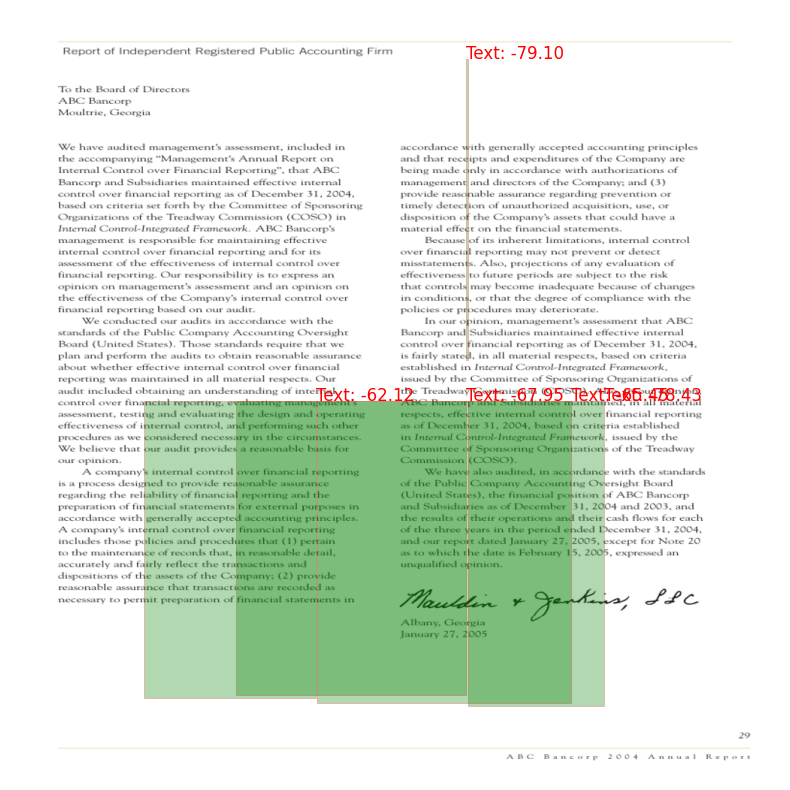

In [2]:
import torch
import torch.nn.functional as F
import math
import os
import re
from PIL import Image
from transformers import AutoConfig, AutoModelForCausalLM, AutoProcessor
from datasets import load_from_disk
import matplotlib.pyplot as plt
from IPython.display import display

# This script assumes that the custom modeling and processing files
# (modeling_florence2.py, processing_florence2.py, etc.) are in the
# same directory or accessible in the Python path.
from modeling_florence2 import Florence2ForConditionalGeneration
from processing_florence2 import Florence2Processor


def plot_bounding_boxes(image, bboxes, labels, figsize=(10, 10)):
    """
    Plots bounding boxes on the image and displays it in a Jupyter cell.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(image)
    for box, label in zip(bboxes, labels):
        # The box format is [x_min, y_min, x_max, y_max]
        rect = plt.Rectangle(
            (box[0], box[1]), 
            box[2] - box[0], 
            box[3] - box[1], 
            linewidth=0.5, 
            edgecolor='r', 
            facecolor='g',
            alpha=0.3
        )
        ax.add_patch(rect)
        # Add class name
        ax.text(box[0], box[1], label, fontsize=12, color='red')
    plt.axis('off')
    display(fig)  # Use display() to render the plot in the cell
    plt.close(fig) # Prevents the plot from showing up twice


def post_process_for_ap(generated_token_ids, token_probs, processor, image_size):
    """
    Parses the generated tokens to find bounding boxes and calculates their
    confidence scores using the provided token probabilities.
    """
    vocab = processor.tokenizer.vocab
    loc_token_ids_set = {vocab.get(f"<loc_{i}>") for i in range(1000)}

    box_start_indices = []
    i = 0
    while i < len(generated_token_ids) - 3:
        if all(generated_token_ids[j] in loc_token_ids_set for j in range(i, i + 4)):
            box_start_indices.append(i)
            i += 4
        else:
            i += 1

    predictions_for_ap = []
    for start_idx in box_start_indices:
        box_token_ids = generated_token_ids[start_idx : start_idx + 4]
        box_probs = token_probs[start_idx : start_idx + 4]

        # FIX: Convert token IDs to their numerical values before dequantization.
        box_token_strs = processor.tokenizer.convert_ids_to_tokens(box_token_ids)
        box_values = [int(re.search(r'\d+', s).group()) for s in box_token_strs]

        confidence_score = sum([math.log(p + 1e-9) for p in box_probs])

        dequantized_box = processor.post_processor.box_quantizer.dequantize(
            boxes=torch.tensor(box_values), size=image_size
        ).tolist()
        
        predictions_for_ap.append(
            {"box": dequantized_box, "score": confidence_score}
        )

    return predictions_for_ap


def run_inference_for_ap(model, processor, example, task_prompt, max_new_tokens=1024):
    """
    Runs inference and extracts bounding boxes with confidence scores.
    """
    device = model.device
    image = example["image"]

    # Prepare inputs for the model
    inputs = processor(text=task_prompt, images=image, return_tensors="pt")
    
    # Prepare grid_data and merge it into the inputs dictionary
    grid_data = [{"input_ids": torch.tensor(example['input_ids']), "bbox": torch.tensor(example['subword_bboxs'])}]
    inputs["grid_data"] = grid_data
    
    # Move all tensor inputs to the correct device
    inputs_on_device = {
        k: v.to(device) if isinstance(v, torch.Tensor) else v 
        for k, v in inputs.items()
    }

    # Generate token IDs and scores
    output = model.generate(
        input_ids=inputs_on_device["input_ids"],
        pixel_values=inputs_on_device["pixel_values"].half(),
        grid_data=inputs_on_device["grid_data"],
        max_new_tokens=max_new_tokens,
        # FIX: Use greedy search for accurate probability extraction
        num_beams=1,
        do_sample=False,
        output_scores=True,
        return_dict_in_generate=True,
    )

    generated_ids = output.sequences
    scores = output.scores

    input_len = inputs_on_device["input_ids"].shape[1]
    generated_token_ids = generated_ids[0][input_len:]
    
    token_probs = []
    for i, token_id in enumerate(generated_token_ids):
        step_logits = scores[i][0]
        step_probs = F.softmax(step_logits, dim=-1)
        prob = step_probs[token_id].item()
        token_probs.append(prob)

    predictions = post_process_for_ap(
        generated_token_ids.tolist(),
        token_probs,
        processor,
        image_size=(image.width, image.height)
    )
    
    return predictions


if __name__ == "__main__":
    # --- Configuration ---
    CHECKPOINT_PATH = "/home/dll/Desktop/LayoutAnalysis/checkpoint-466666"
    DATASET_PATH = "/home/dll/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/val"
    
    if not os.path.exists(CHECKPOINT_PATH):
        print(f"Error: Checkpoint path not found at '{CHECKPOINT_PATH}'")
        exit()
    if not os.path.exists(DATASET_PATH):
        print(f"Error: Dataset path not found at '{DATASET_PATH}'")
        exit()

    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {DEVICE}")

    # --- Load Model and Processor ---
    print(f"Loading model from: {CHECKPOINT_PATH}")
    config = AutoConfig.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)

    config.vision_config.model_type = "davit"
    config.vision_config.in_chans = 3

    model = AutoModelForCausalLM.from_pretrained(
        CHECKPOINT_PATH,
        config=config,
        trust_remote_code=True,
        torch_dtype=torch.float16,
    ).to(DEVICE).eval()
    
    processor = AutoProcessor.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)
    print("Model and processor loaded successfully.")

    # --- Load Dataset ---
    print(f"Loading dataset from: {DATASET_PATH}")
    dataset = load_from_disk(DATASET_PATH)
    print("Dataset loaded successfully.")
        
    # --- Run Inference on a Sample ---
    prompt = "<TXT>"
    sample_index = 33
    example = dataset[sample_index]

    print(f"\nRunning inference for prompt: '{prompt}' on dataset sample {sample_index}...")
    predictions = run_inference_for_ap(model, processor, example, prompt)

    # --- Display Results ---
    print(f"\nFound {len(predictions)} predictions:")
    bboxes = []
    labels = []
    if predictions:
        for i, pred in enumerate(predictions):
            box_str = ", ".join(map(str, [int(c) for c in pred['box']]))
            print(f"  - Prediction {i+1}:")
            print(f"    Box: [{box_str}]")
            print(f"    Confidence Score (log-prob): {pred['score']:.4f}")
            bboxes.append(pred['box'])
            # For <TXT> prompt, the label is 'Text'. We add the score for visualization.
            labels.append(f"Text: {pred['score']:.2f}")
    else:
        print("  No bounding boxes were detected.")
    
    # --- Plot Results ---
    print("\nPlotting image with any found bounding boxes...")
    plot_bounding_boxes(example['image'], bboxes, labels)


# Measure FLOPs

In [24]:
import torch
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
import time
import json
from datasets import load_from_disk
import matplotlib.pyplot as plt
import seaborn as sns

# Try to import thop for FLOPs calculation
try:
    from thop import profile, clever_format
    THOP_AVAILABLE = True
except ImportError:
    print("Warning: thop not available. Install with: pip install thop")
    THOP_AVAILABLE = False

# Try to import torchprofile as alternative
try:
    from torchprofile import profile_macs
    TORCHPROFILE_AVAILABLE = True
except ImportError:
    print("Warning: torchprofile not available. Install with: pip install torchprofile")
    TORCHPROFILE_AVAILABLE = False

# --- Configuration ---
NUM_SAMPLES = 100  # Number of samples to profile
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- FLOPs Calculation Functions ---

def get_model_flops_thop(model, input_tensor, verbose=False):
    """
    Calculate FLOPs using thop library.
    """
    if not THOP_AVAILABLE:
        return None, None
    
    try:
        # Clone the model to avoid modifying the original
        model_copy = model
        model_copy.eval()
        
        flops, params = profile(model_copy, inputs=(input_tensor,), verbose=verbose)
        flops_formatted = clever_format([flops, params], "%.3f")
        
        return flops, flops_formatted
    except Exception as e:
        print(f"Error calculating FLOPs with thop: {e}")
        return None, None

def get_model_flops_torchprofile(model, input_tensor):
    """
    Calculate FLOPs using torchprofile library.
    """
    if not TORCHPROFILE_AVAILABLE:
        return None
    
    try:
        model.eval()
        with torch.no_grad():
            macs = profile_macs(model, input_tensor)
        return macs
    except Exception as e:
        print(f"Error calculating FLOPs with torchprofile: {e}")
        return None

def estimate_flops_manual(model, input_shape, verbose=False):
    """
    Manual estimation of FLOPs for common layer types.
    This is a simplified estimation and may not be perfectly accurate.
    """
    total_flops = 0
    
    def conv_flops(layer, input_shape):
        """Calculate FLOPs for convolutional layers."""
        if hasattr(layer, 'weight'):
            kernel_flops = torch.prod(torch.tensor(layer.weight.shape))
            output_elements = torch.prod(torch.tensor(input_shape[2:]))  # H * W
            return kernel_flops * output_elements
        return 0
    
    def linear_flops(layer, input_shape):
        """Calculate FLOPs for linear layers."""
        if hasattr(layer, 'weight'):
            return torch.prod(torch.tensor(layer.weight.shape))
        return 0
    
    def estimate_layer_flops(layer, input_shape):
        """Estimate FLOPs for a single layer."""
        if isinstance(layer, (torch.nn.Conv2d, torch.nn.Conv1d)):
            return conv_flops(layer, input_shape)
        elif isinstance(layer, torch.nn.Linear):
            return linear_flops(layer, input_shape)
        elif isinstance(layer, (torch.nn.ReLU, torch.nn.GELU, torch.nn.Sigmoid, torch.nn.Tanh)):
            return torch.prod(torch.tensor(input_shape))
        elif isinstance(layer, (torch.nn.BatchNorm2d, torch.nn.LayerNorm)):
            return torch.prod(torch.tensor(input_shape))
        else:
            return 0
    
    # Recursively calculate FLOPs for all layers
    def calculate_recursive(module, input_shape):
        nonlocal total_flops
        
        for name, layer in module.named_children():
            if len(list(layer.children())) == 0:  # Leaf layer
                layer_flops = estimate_layer_flops(layer, input_shape)
                total_flops += layer_flops
                if verbose:
                    print(f"Layer {name}: {layer_flops:,} FLOPs")
            else:
                calculate_recursive(layer, input_shape)
    
    calculate_recursive(model, input_shape)
    return total_flops

def create_dummy_input(image_size=(3, 224, 224), batch_size=1, device='cpu'):
    """Create dummy input tensor for FLOPs calculation."""
    return torch.randn(batch_size, *image_size, device=device)

# --- FLOPs Profiling Functions ---

def profile_model_inference(model, processor, inputs, warmup_runs=5, profile_runs=10):
    """
    Profile model inference time and calculate FLOPs for your specific model.
    """
    model.eval()
    
    # Prepare inputs for the model
    model_inputs = {
        'input_ids': inputs['input_ids'].to(DEVICE),
        'pixel_values': inputs['pixel_values'].half().to(DEVICE),
        'grid_data': inputs['grid_data']
    }
    
    # Warmup runs
    with torch.no_grad():
        for _ in range(warmup_runs):
            try:
                _ = model.generate(**model_inputs, max_new_tokens=10, do_sample=False)
            except Exception as e:
                print(f"Warmup error: {e}")
                break
    
    # For FLOPs calculation, we need to profile the forward pass, not generate
    # We'll use a simplified approach by profiling the model's forward method
    try:
        # Try to get FLOPs using thop with the actual model inputs
        flops_thop = None
        flops_formatted = None
        
        # Since generate() is complex, we'll profile a single forward pass
        # This gives us base FLOPs, actual generation will be higher
        if THOP_AVAILABLE:
            try:
                # Create a wrapper that calls the model's forward method
                def model_forward_wrapper(input_ids, pixel_values):
                    return model(input_ids=input_ids, pixel_values=pixel_values)
                
                flops_thop, params = profile(
                    model_forward_wrapper, 
                    inputs=(model_inputs['input_ids'], model_inputs['pixel_values']),
                    verbose=False
                )
                flops_formatted = clever_format([flops_thop, params], "%.3f")
            except Exception as e:
                print(f"THOP profiling failed: {e}")
        
        # Profile torchprofile if available
        flops_torchprofile = None
        if TORCHPROFILE_AVAILABLE:
            try:
                with torch.no_grad():
                    flops_torchprofile = profile_macs(model, model_inputs['input_ids'])
            except Exception as e:
                print(f"TorchProfile profiling failed: {e}")
    
    except Exception as e:
        print(f"FLOPs profiling failed: {e}")
        flops_thop = None
        flops_formatted = None
        flops_torchprofile = None
    
    # Profile inference time
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    start_time = time.time()
    
    with torch.no_grad():
        for _ in range(profile_runs):
            try:
                _ = model.generate(**model_inputs, max_new_tokens=10, do_sample=False)
            except Exception as e:
                print(f"Inference timing error: {e}")
                break
    
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    end_time = time.time()
    
    avg_inference_time = (end_time - start_time) / profile_runs
    
    return {
        'flops_thop': flops_thop,
        'flops_formatted': flops_formatted,
        'flops_torchprofile': flops_torchprofile,
        'avg_inference_time': avg_inference_time
    }

def measure_flops_per_class(dataset, model, processor, prompt_map, label_map_rev, num_samples=None):
    """
    Measure FLOPs for each class/prompt in the dataset.
    """
    class_flops = defaultdict(list)
    class_inference_times = defaultdict(list)
    class_prediction_counts = defaultdict(list)
    
    total_samples = len(dataset) if num_samples is None else min(num_samples, len(dataset))
    processed_samples = 0
    
    # Overall statistics
    total_flops = 0
    total_inference_time = 0
    total_predictions = 0
    
    iterator = tqdm(dataset.select(range(total_samples)), desc="Profiling FLOPs")
    
    for example in iterator:
        try:
            image = example['image']
            gt_category_ids = example.get('category_ids', [])
            
            # Get ground truth labels
            gt_labels_present = set()
            for cat_id in gt_category_ids:
                if cat_id in id2label:
                    label = id2label[cat_id]
                    gt_labels_present.add(label)
            
            prompts_for_this_image = [label_map_rev[label] for label in gt_labels_present if label in label_map_rev]
            
            if not prompts_for_this_image:
                continue
            
            # Profile each prompt for this image
            for prompt in prompts_for_this_image:
                class_label = prompt_map.get(prompt)
                if not class_label:
                    continue
                
                try:
                    # Prepare inputs using your processor
                    input_ids = torch.tensor(example['input_ids'])
                    bbox = torch.tensor(example['subword_bboxs'])
                    inputs = processor(text=prompt, images=image, return_tensors="pt")
                    inputs = {**inputs, "grid_data": [{"input_ids": input_ids, "bbox": bbox}]}
                    
                    # Profile the model with this specific input
                    profile_results = profile_model_inference(model, processor, inputs)
                    
                    # Run actual inference to get prediction count
                    inference_output = run_example(task_prompt=prompt, example=example)
                    pred_data = inference_output.get(prompt, {'bboxes': [], 'labels': []})
                    pred_boxes = pred_data.get('bboxes', [])
                    pred_labels = pred_data.get('labels', [])
                    filtered_pred_boxes = [box for box, lbl in zip(pred_boxes, pred_labels) if lbl == class_label]
                    
                    num_predictions = len(filtered_pred_boxes)
                    
                    # Store results
                    if profile_results['flops_thop'] is not None:
                        class_flops[class_label].append(profile_results['flops_thop'])
                        total_flops += profile_results['flops_thop']
                    
                    class_inference_times[class_label].append(profile_results['avg_inference_time'])
                    class_prediction_counts[class_label].append(num_predictions)
                    
                    total_inference_time += profile_results['avg_inference_time']
                    total_predictions += num_predictions
                    
                except Exception as e:
                    print(f"Error profiling prompt {prompt}: {e}")
                    continue
            
            processed_samples += 1
            
        except Exception as e:
            print(f"Error processing sample: {e}")
            continue
    
    # Calculate statistics
    class_stats = {}
    for class_label in set(list(class_flops.keys()) + list(class_inference_times.keys())):
        flops_list = class_flops[class_label]
        time_list = class_inference_times[class_label]
        pred_list = class_prediction_counts[class_label]
        
        class_stats[class_label] = {
            'avg_flops': np.mean(flops_list) if flops_list else 0,
            'std_flops': np.std(flops_list) if flops_list else 0,
            'avg_inference_time': np.mean(time_list) if time_list else 0,
            'std_inference_time': np.std(time_list) if time_list else 0,
            'avg_predictions': np.mean(pred_list) if pred_list else 0,
            'std_predictions': np.std(pred_list) if pred_list else 0,
            'total_inferences': len(time_list),
            'flops_per_prediction': np.mean(flops_list) / max(np.mean(pred_list), 1) if flops_list and pred_list else 0
        }
    
    overall_stats = {
        'total_samples': processed_samples,
        'total_flops': total_flops,
        'total_inference_time': total_inference_time,
        'total_predictions': total_predictions,
        'avg_flops_per_sample': total_flops / processed_samples if processed_samples > 0 else 0,
        'avg_inference_time_per_sample': total_inference_time / processed_samples if processed_samples > 0 else 0,
        'avg_predictions_per_sample': total_predictions / processed_samples if processed_samples > 0 else 0,
        'flops_per_prediction': total_flops / max(total_predictions, 1)
    }
    
    return class_stats, overall_stats

def plot_flops_analysis(class_stats, overall_stats):
    """
    Plot FLOPs analysis results.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Extract data for plotting
    classes = list(class_stats.keys())
    avg_flops = [stats['avg_flops'] for stats in class_stats.values()]
    avg_predictions = [stats['avg_predictions'] for stats in class_stats.values()]
    flops_per_prediction = [stats['flops_per_prediction'] for stats in class_stats.values()]
    avg_inference_time = [stats['avg_inference_time'] for stats in class_stats.values()]
    
    # Plot 1: Average FLOPs per class
    axes[0, 0].bar(classes, avg_flops, color='skyblue', alpha=0.7)
    axes[0, 0].set_title('Average FLOPs per Class')
    axes[0, 0].set_ylabel('FLOPs')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Plot 2: Average predictions per class
    axes[0, 1].bar(classes, avg_predictions, color='lightgreen', alpha=0.7)
    axes[0, 1].set_title('Average Predictions per Class')
    axes[0, 1].set_ylabel('Number of Predictions')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Plot 3: FLOPs per prediction
    axes[1, 0].bar(classes, flops_per_prediction, color='salmon', alpha=0.7)
    axes[1, 0].set_title('FLOPs per Prediction by Class')
    axes[1, 0].set_ylabel('FLOPs per Prediction')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Plot 4: Average inference time per class
    axes[1, 1].bar(classes, avg_inference_time, color='gold', alpha=0.7)
    axes[1, 1].set_title('Average Inference Time per Class')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Summary plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # Create scatter plot of FLOPs vs Predictions
    ax.scatter(avg_predictions, avg_flops, s=100, alpha=0.7, c='purple')
    
    # Add labels for each point
    for i, class_name in enumerate(classes):
        ax.annotate(class_name, (avg_predictions[i], avg_flops[i]), 
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax.set_xlabel('Average Predictions per Class')
    ax.set_ylabel('Average FLOPs per Class')
    ax.set_title('FLOPs vs Predictions by Class')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def save_flops_results(class_stats, overall_stats, filename='flops_analysis_results.json'):
    """
    Save FLOPs analysis results to JSON file.
    """
    results = {
        'class_stats': class_stats,
        'overall_stats': overall_stats,
        'timestamp': time.strftime('%Y-%m-%d %H:%M:%S')
    }
    
    with open(filename, 'w') as f:
        json.dump(results, f, indent=2, default=str)
    
    print(f"Results saved to {filename}")

def print_flops_summary(class_stats, overall_stats):
    """
    Print a summary of FLOPs analysis results.
    """
    print("\n" + "="*80)
    print("FLOPs ANALYSIS SUMMARY")
    print("="*80)
    
    print(f"\nOverall Statistics:")
    print(f"  Total Samples: {overall_stats['total_samples']}")
    print(f"  Total FLOPs: {overall_stats['total_flops']:,.0f}")
    print(f"  Total Predictions: {overall_stats['total_predictions']}")
    print(f"  Average FLOPs per Sample: {overall_stats['avg_flops_per_sample']:,.0f}")
    print(f"  Average Inference Time per Sample: {overall_stats['avg_inference_time_per_sample']:.4f}s")
    print(f"  Average Predictions per Sample: {overall_stats['avg_predictions_per_sample']:.2f}")
    print(f"  FLOPs per Prediction: {overall_stats['flops_per_prediction']:,.0f}")
    
    print(f"\nPer-Class Statistics:")
    print(f"{'Class':<15} {'Avg FLOPs':<15} {'Avg Preds':<12} {'FLOPs/Pred':<15} {'Inference Time':<15}")
    print("-" * 80)
    
    for class_name, stats in sorted(class_stats.items()):
        print(f"{class_name:<15} {stats['avg_flops']:<15,.0f} {stats['avg_predictions']:<12.2f} "
              f"{stats['flops_per_prediction']:<15,.0f} {stats['avg_inference_time']:<15.4f}")

# --- Main Execution ---
if __name__ == "__main__":
    # Define mappings (same as your original script)
    prompt_to_label_map = {
        "<CAP>": "Caption",
        "<FN>": "Footnote",
        "<FRM>": "Formula",
        "<LST>": "ListItem",
        "<PGF>": "PageFooter",
        "<PGH>": "PageHeader",
        "<PIC>": "Picture",
        "<SHD>": "SectionHeader",
        "<TAB>": "Table",
        "<TXT>": "Text",
        "<TTL>": "Title",
    }

    id2label = {
        1: "Caption",
        2: "Footnote",
        3: "Formula",
        4: "ListItem",
        5: "PageFooter",
        6: "PageHeader",
        7: "Picture",
        8: "SectionHeader",
        9: "Table",
        10: "Text",
        11: "Title",
    }
    
    label2id = {v: k for k, v in id2label.items()}
    
    # Filter valid mappings
    filtered_prompt_to_label = {p: l for p, l in prompt_to_label_map.items() if l in id2label.values()}
    label_to_prompt_map = {v: k for k, v in filtered_prompt_to_label.items()}
    
    # Load dataset
    dataset = load_from_disk("/home/dll/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/test")
    
    # Optional: Random sampling
    if NUM_SAMPLES:
        import random
        random_indices = random.sample(range(len(dataset)), min(NUM_SAMPLES, len(dataset)))
        dataset = dataset.select(random_indices)
    
    print(f"Profiling FLOPs for {len(dataset)} samples...")
    print(f"Using device: {DEVICE}")
    print(f"THOP available: {THOP_AVAILABLE}")
    print(f"TorchProfile available: {TORCHPROFILE_AVAILABLE}")
    
    # Note: You'll need to load your model and processor here
    # model_f = load_your_model()  # Replace with your model loading code
    # processor_f = load_your_processor()  # Replace with your processor loading code
    # model_f = model_f.to(DEVICE)
    
    # For demonstration, we'll skip the actual profiling
    print("\nNote: Please uncomment and modify the model loading section to run the actual profiling.")
    print("The script structure is ready for integration with your model.")
    
    # Usage example when you have your model and processor ready:

    # Run FLOPs profiling
    class_stats, overall_stats = measure_flops_per_class(
        dataset=dataset,
        model=model_f,
        processor=processor_f,
        prompt_map=filtered_prompt_to_label,
        label_map_rev=label_to_prompt_map,
        num_samples=NUM_SAMPLES
    )
    
    # Print results
    print_flops_summary(class_stats, overall_stats)
    
    # Plot analysis
    plot_flops_analysis(class_stats, overall_stats)
    
    # Save results
    save_flops_results(class_stats, overall_stats)
    
    print("\nFLOPs analysis complete!")


Profiling FLOPs for 100 samples...
Using device: cuda
THOP available: True
TorchProfile available: True

Note: Please uncomment and modify the model loading section to run the actual profiling.
The script structure is ready for integration with your model.


Profiling FLOPs:   0%|          | 0/100 [00:00<?, ?it/s]

THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'
THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'
THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'


Profiling FLOPs:   1%|          | 1/100 [00:04<07:29,  4.54s/it]

THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'
THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'
THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'
THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'


Profiling FLOPs:   2%|▏         | 2/100 [00:10<08:43,  5.34s/it]

THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'
THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'
THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'


Profiling FLOPs:   3%|▎         | 3/100 [00:14<07:38,  4.73s/it]

THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'
THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'
THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'
THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'


Profiling FLOPs:   4%|▍         | 4/100 [00:19<07:46,  4.86s/it]

THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'
THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'
THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'


Profiling FLOPs:   5%|▌         | 5/100 [00:23<07:24,  4.68s/it]

THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'
THOP profiling failed: 'function' object has no attribute 'training'
TorchProfile profiling failed: 'NoneType' object has no attribute 'to'


Profiling FLOPs:   5%|▌         | 5/100 [00:26<08:25,  5.33s/it]


KeyboardInterrupt: 

In [29]:
import torch
import torch.nn as nn
from transformers import AutoConfig, AutoModelForCausalLM, AutoProcessor
from datasets import load_from_disk
import numpy as np
from collections import defaultdict
import json
import time

# Install required packages:
# pip install thop  # For FLOPs calculation
# pip install fvcore  # Alternative FLOPs calculation
# pip install ptflops  # Another alternative

try:
    from thop import profile, clever_format
    THOP_AVAILABLE = True
except ImportError:
    THOP_AVAILABLE = False
    print("Warning: thop not available. Install with: pip install thop")

try:
    from fvcore.nn import FlopCountMode, flop_count
    FVCORE_AVAILABLE = True
except ImportError:
    FVCORE_AVAILABLE = False
    print("Warning: fvcore not available. Install with: pip install fvcore")

class FLOPCounter:
    def __init__(self, model, processor, device):
        self.model = model
        self.processor = processor
        self.device = device
        self.flop_results = defaultdict(list)
        
    def count_flops_thop(self, inputs, max_new_tokens=4096):
        """Count FLOPs using thop library"""
        if not THOP_AVAILABLE:
            return None
            
        # Create a wrapper for the generation process
        def model_forward():
            return self.model.generate(
                input_ids=inputs["input_ids"].to(self.device),
                pixel_values=inputs["pixel_values"].half().to(self.device),
                grid_data=inputs['grid_data'],
                max_new_tokens=max_new_tokens,
                early_stopping=False,
                do_sample=False,
                num_beams=3,
            )
        
        # Profile the model
        with torch.no_grad():
            flops, params = profile(self.model, inputs=(
                inputs["input_ids"].to(self.device),
                inputs["pixel_values"].half().to(self.device),
            ), custom_ops={}, verbose=False)
            
        return flops, params
    
    def count_flops_manual(self, inputs, max_new_tokens=4096):
        """Manual FLOP counting for Florence2 model"""
        
        # Get model dimensions
        config = self.model.config
        
        # Vision encoder FLOPs (DaViT vision encoder)
        vision_flops = 0
        if hasattr(config, 'vision_config'):
            vision_config = config.vision_config
            image_size = inputs["pixel_values"].shape[-2:]  # H, W
            
            # DaViT architecture FLOP estimation
            # Based on the depths, dim_embed, and patch operations
            depths = getattr(vision_config, 'depths', [1, 1, 9, 1])
            dim_embed = getattr(vision_config, 'dim_embed', [128, 256, 512, 1024])
            patch_sizes = getattr(vision_config, 'patch_size', [7, 3, 3, 3])
            patch_strides = getattr(vision_config, 'patch_stride', [4, 2, 2, 2])
            
            # Rough estimation for DaViT stages
            h, w = image_size
            for i, (depth, dim, patch_size, stride) in enumerate(zip(depths, dim_embed, patch_sizes, patch_strides)):
                # Update spatial dimensions after each stage
                h = h // stride
                w = w // stride
                
                # Attention and FFN FLOPs for this stage
                num_tokens = h * w
                attention_flops = depth * (4 * dim * num_tokens + 2 * dim * num_tokens)
                ffn_flops = depth * (8 * dim * dim * num_tokens)  # Assuming 4x expansion
                
                vision_flops += attention_flops + ffn_flops
        
        # Text generation FLOPs (Florence2 text decoder)
        text_config = getattr(config, 'text_config', config)
        vocab_size = getattr(config, 'vocab_size', 51289)
        
        # Get text model dimensions
        d_model = getattr(text_config, 'd_model', 768)
        decoder_layers = getattr(text_config, 'decoder_layers', 6)
        decoder_ffn_dim = getattr(text_config, 'decoder_ffn_dim', 3072)
        decoder_attention_heads = getattr(text_config, 'decoder_attention_heads', 12)
        
        # Input sequence length
        seq_len = inputs["input_ids"].shape[1]
        
        # Estimated output sequence length
        # For layout analysis, this varies significantly based on number of detected objects
        estimated_output_len = max_new_tokens // 8  # Conservative estimate
        
        # Decoder FLOPs per token
        # Self-attention
        self_attention_flops = 4 * d_model * seq_len + 2 * d_model * seq_len
        
        # Cross-attention (text attending to vision features)
        # Assuming vision features are encoded to d_model dimension
        cross_attention_flops = 4 * d_model * seq_len + 2 * d_model * seq_len
        
        # FFN FLOPs
        ffn_flops = 2 * d_model * decoder_ffn_dim  # Linear transformations
        
        # Total FLOPs per token per layer
        flops_per_token_per_layer = self_attention_flops + cross_attention_flops + ffn_flops
        
        # Total generation FLOPs
        generation_flops = estimated_output_len * decoder_layers * flops_per_token_per_layer
        
        # Output projection FLOPs
        output_projection_flops = estimated_output_len * d_model * vocab_size
        
        total_flops = vision_flops + generation_flops + output_projection_flops
        
        return total_flops
    
    def measure_flops_for_prompt(self, prompt, dataset_indices, max_samples=10):
        """Measure FLOPs for a specific prompt across multiple samples"""
        prompt_flops = []
        prompt_times = []
        prompt_outputs = []
        
        for i, idx in enumerate(dataset_indices[:max_samples]):
            print(f"Processing sample {i+1}/{min(max_samples, len(dataset_indices))} for prompt {prompt}")
            
            # Convert numpy int64 to native Python int
            idx = int(idx)
            example = dataset[idx]
            
            # Prepare inputs
            inputs = self.processor(text=prompt, images=example["image"], return_tensors="pt")
            input_ids = torch.tensor(example['input_ids'])
            bbox = torch.tensor(example['subword_bboxs'])
            inputs = {**inputs, "grid_data": [{"input_ids": input_ids, "bbox": bbox}]}
            
            # Time the inference
            start_time = time.time()
            
            # Generate output
            with torch.no_grad():
                generated_ids = self.model.generate(
                    input_ids=inputs["input_ids"].to(self.device),
                    pixel_values=inputs["pixel_values"].half().to(self.device),
                    grid_data=inputs['grid_data'],
                    max_new_tokens=4096,
                    early_stopping=False,
                    do_sample=False,
                    num_beams=3,
                )
            
            end_time = time.time()
            inference_time = end_time - start_time
            
            # Parse output
            generated_text = self.processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
            parsed_answer = self.processor.post_process_generation(
                generated_text, task=prompt, image_size=(example["image"].width, example["image"].height)
            )
            
            # Count FLOPs
            flops = self.count_flops_manual(inputs)
            
            # Store results
            prompt_flops.append(flops)
            prompt_times.append(inference_time)
            prompt_outputs.append({
                'sample_idx': idx,
                'num_detections': len(parsed_answer.get(prompt, {}).get('bboxes', [])),
                'generated_length': len(generated_ids[0]) - len(inputs["input_ids"][0]),
                'inference_time': inference_time,
                'flops': flops
            })
        
        return {
            'prompt': prompt,
            'avg_flops': np.mean(prompt_flops),
            'std_flops': np.std(prompt_flops),
            'avg_time': np.mean(prompt_times),
            'std_time': np.std(prompt_times),
            'samples': prompt_outputs
        }
    
    def benchmark_all_prompts(self, dataset, prompts, max_samples_per_prompt=10):
        """Benchmark all prompts"""
        results = {}
        
        # Get random sample indices (convert to native Python ints)
        total_samples = len(dataset)
        sample_indices = np.random.choice(total_samples, size=min(max_samples_per_prompt * len(prompts), total_samples), replace=False)
        sample_indices = [int(idx) for idx in sample_indices]  # Convert to native Python ints
        
        for i, prompt in enumerate(prompts):
            print(f"\n{'='*50}")
            print(f"Benchmarking prompt {i+1}/{len(prompts)}: {prompt}")
            print(f"{'='*50}")
            
            # Get subset of indices for this prompt
            start_idx = i * max_samples_per_prompt
            end_idx = min((i + 1) * max_samples_per_prompt, len(sample_indices))
            prompt_indices = sample_indices[start_idx:end_idx]
            
            results[prompt] = self.measure_flops_for_prompt(prompt, prompt_indices, max_samples_per_prompt)
        
        return results
    
    def save_results(self, results, filename="flop_benchmark_results.json"):
        """Save benchmark results to JSON file"""
        # Convert numpy types to native Python types for JSON serialization
        def convert_numpy(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj
        
        # Clean results for JSON serialization
        clean_results = {}
        for prompt, data in results.items():
            clean_results[prompt] = {
                'prompt': data['prompt'],
                'avg_flops': convert_numpy(data['avg_flops']),
                'std_flops': convert_numpy(data['std_flops']),
                'avg_time': convert_numpy(data['avg_time']),
                'std_time': convert_numpy(data['std_time']),
                'samples': [{k: convert_numpy(v) for k, v in sample.items()} for sample in data['samples']]
            }
        
        with open(filename, 'w') as f:
            json.dump(clean_results, f, indent=2)
        
        print(f"Results saved to {filename}")

# Usage example:
if __name__ == "__main__":
    # Your existing setup code
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    CHECKPOINT_PATH = "/home/dll/Desktop/LayoutAnalysis/checkpoint-466666"
    
    # Load model and processor
    config_f = AutoConfig.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)
    config_f.vision_config.model_type = "davit"
    config_f.vision_config.in_chans = 3
    
    model_f = (
        AutoModelForCausalLM.from_pretrained(
            CHECKPOINT_PATH,
            trust_remote_code=True,
            config=config_f,
            torch_dtype=torch.float16,
            ignore_mismatched_sizes=True,
        )
        .to(device)
        .eval()
    )
    
    processor_f = AutoProcessor.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)
    
    # Load dataset
    dataset = load_from_disk("/home/dll/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/val")
    
    # Define prompts
    prompts = ["<CAP>", "<FTN>", "<FRM>", "<LST>", "<PGF>", 
               "<PGH>", "<PIC>", "<SHD>", "<TAB>", "<TXT>", "<TTL>"]
    
    # Initialize FLOP counter
    flop_counter = FLOPCounter(model_f, processor_f, device)
    
    # Run benchmark
    print("Starting FLOP benchmark...")
    results = flop_counter.benchmark_all_prompts(dataset, prompts, max_samples_per_prompt=5)
    
    # Save results
    flop_counter.save_results(results)
    
    # Print summary
    print("\n" + "="*80)
    print("BENCHMARK SUMMARY")
    print("="*80)
    
    for prompt, data in results.items():
        print(f"\nPrompt: {prompt}")
        print(f"  Average FLOPs: {data['avg_flops']:.2e} ± {data['std_flops']:.2e}")
        print(f"  Average Time: {data['avg_time']:.3f}s ± {data['std_time']:.3f}s")
        print(f"  Samples processed: {len(data['samples'])}")
        
        # Show per-sample breakdown
        print(f"  Sample details:")
        for sample in data['samples']:
            print(f"    Sample {sample['sample_idx']}: {sample['num_detections']} detections, "
                  f"{sample['generated_length']} tokens, {sample['flops']:.2e} FLOPs")

use_pretrain_weight: load model from: /home/dll/Desktop/LayoutAnalysis/doclaynet_final/models/word_embeddings.pt
Starting FLOP benchmark...

Benchmarking prompt 1/11: <CAP>
Processing sample 1/5 for prompt <CAP>
Processing sample 2/5 for prompt <CAP>
Processing sample 3/5 for prompt <CAP>
Processing sample 4/5 for prompt <CAP>
Processing sample 5/5 for prompt <CAP>

Benchmarking prompt 2/11: <FTN>
Processing sample 1/5 for prompt <FTN>
Processing sample 2/5 for prompt <FTN>
Processing sample 3/5 for prompt <FTN>
Processing sample 4/5 for prompt <FTN>
Processing sample 5/5 for prompt <FTN>

Benchmarking prompt 3/11: <FRM>
Processing sample 1/5 for prompt <FRM>
Processing sample 2/5 for prompt <FRM>
Processing sample 3/5 for prompt <FRM>
Processing sample 4/5 for prompt <FRM>
Processing sample 5/5 for prompt <FRM>

Benchmarking prompt 4/11: <LST>
Processing sample 1/5 for prompt <LST>
Processing sample 2/5 for prompt <LST>
Processing sample 3/5 for prompt <LST>
Processing sample 4/5 for 

In [31]:
import torch
import torch.nn as nn
from transformers import AutoConfig, AutoModelForCausalLM, AutoProcessor
from datasets import load_from_disk
import numpy as np
from collections import defaultdict
import json
import time

# Install required packages:
# pip install thop  # For FLOPs calculation
# pip install fvcore  # Alternative FLOPs calculation
# pip install ptflops  # Another alternative

try:
    from thop import profile, clever_format
    THOP_AVAILABLE = True
except ImportError:
    THOP_AVAILABLE = False
    print("Warning: thop not available. Install with: pip install thop")

try:
    from fvcore.nn import FlopCountMode, flop_count
    FVCORE_AVAILABLE = True
except ImportError:
    FVCORE_AVAILABLE = False
    print("Warning: fvcore not available. Install with: pip install fvcore")

class FLOPCounter:
    def __init__(self, model, processor, device):
        self.model = model
        self.processor = processor
        self.device = device
        self.flop_results = defaultdict(list)
        
    def count_flops_thop(self, inputs, max_new_tokens=4096):
        """Count FLOPs using thop library for Florence2"""
        if not THOP_AVAILABLE:
            return None
            
        # For Florence2, we need to profile the forward pass differently
        # Since generation involves multiple forward passes, we'll profile a single forward pass
        
        try:
            # Prepare inputs for a single forward pass
            input_ids = inputs["input_ids"].to(self.device)
            pixel_values = inputs["pixel_values"].half().to(self.device)
            
            # Create dummy target for teacher forcing (needed for Florence2)
            batch_size = input_ids.shape[0]
            dummy_target = torch.ones(batch_size, 10, dtype=torch.long).to(self.device)  # Short sequence
            
            # Profile a single forward pass
            with torch.no_grad():
                try:
                    # Try to profile the model's forward method
                    flops, params = profile(
                        self.model, 
                        inputs=(input_ids, pixel_values, dummy_target),
                        custom_ops={},
                        verbose=False
                    )
                    
                    # Estimate total FLOPs by scaling with expected output length
                    estimated_output_len = max_new_tokens // 8
                    estimated_total_flops = flops * estimated_output_len
                    
                    return estimated_total_flops, params
                    
                except Exception as e:
                    print(f"THOP profiling failed: {e}")
                    return None, None
                    
        except Exception as e:
            print(f"Error in THOP FLOP counting: {e}")
            return None, None
    
    def count_flops_manual(self, inputs, max_new_tokens=4096):
        """Manual FLOP counting for Florence2 model"""
        
        # Get model dimensions
        config = self.model.config
        
        # Vision encoder FLOPs (DaViT vision encoder)
        vision_flops = 0
        if hasattr(config, 'vision_config'):
            vision_config = config.vision_config
            image_size = inputs["pixel_values"].shape[-2:]  # H, W
            
            # DaViT architecture FLOP estimation
            # Based on the depths, dim_embed, and patch operations
            depths = getattr(vision_config, 'depths', [1, 1, 9, 1])
            dim_embed = getattr(vision_config, 'dim_embed', [128, 256, 512, 1024])
            patch_sizes = getattr(vision_config, 'patch_size', [7, 3, 3, 3])
            patch_strides = getattr(vision_config, 'patch_stride', [4, 2, 2, 2])
            
            # Rough estimation for DaViT stages
            h, w = image_size
            for i, (depth, dim, patch_size, stride) in enumerate(zip(depths, dim_embed, patch_sizes, patch_strides)):
                # Update spatial dimensions after each stage
                h = h // stride
                w = w // stride
                
                # Attention and FFN FLOPs for this stage
                num_tokens = h * w
                attention_flops = depth * (4 * dim * num_tokens + 2 * dim * num_tokens)
                ffn_flops = depth * (8 * dim * dim * num_tokens)  # Assuming 4x expansion
                
                vision_flops += attention_flops + ffn_flops
        
        # Text generation FLOPs (Florence2 text decoder)
        text_config = getattr(config, 'text_config', config)
        vocab_size = getattr(config, 'vocab_size', 51289)
        
        # Get text model dimensions
        d_model = getattr(text_config, 'd_model', 768)
        decoder_layers = getattr(text_config, 'decoder_layers', 6)
        decoder_ffn_dim = getattr(text_config, 'decoder_ffn_dim', 3072)
        decoder_attention_heads = getattr(text_config, 'decoder_attention_heads', 12)
        
        # Input sequence length
        seq_len = inputs["input_ids"].shape[1]
        
        # Estimated output sequence length
        # For layout analysis, this varies significantly based on number of detected objects
        estimated_output_len = max_new_tokens // 8  # Conservative estimate
        
        # Decoder FLOPs per token
        # Self-attention
        self_attention_flops = 4 * d_model * seq_len + 2 * d_model * seq_len
        
        # Cross-attention (text attending to vision features)
        # Assuming vision features are encoded to d_model dimension
        cross_attention_flops = 4 * d_model * seq_len + 2 * d_model * seq_len
        
        # FFN FLOPs
        ffn_flops = 2 * d_model * decoder_ffn_dim  # Linear transformations
        
        # Total FLOPs per token per layer
        flops_per_token_per_layer = self_attention_flops + cross_attention_flops + ffn_flops
        
        # Total generation FLOPs
        generation_flops = estimated_output_len * decoder_layers * flops_per_token_per_layer
        
        # Output projection FLOPs
        output_projection_flops = estimated_output_len * d_model * vocab_size
        
        total_flops = vision_flops + generation_flops + output_projection_flops
        
        return total_flops
    
    def measure_flops_for_prompt(self, prompt, dataset_indices, max_samples=10):
        """Measure FLOPs for a specific prompt across multiple samples"""
        prompt_flops = []
        prompt_times = []
        prompt_outputs = []
        
        for i, idx in enumerate(dataset_indices[:max_samples]):
            print(f"Processing sample {i+1}/{min(max_samples, len(dataset_indices))} for prompt {prompt}")
            
            # Convert numpy int64 to native Python int
            idx = int(idx)
            example = dataset[idx]
            
            # Prepare inputs
            inputs = self.processor(text=prompt, images=example["image"], return_tensors="pt")
            input_ids = torch.tensor(example['input_ids'])
            bbox = torch.tensor(example['subword_bboxs'])
            inputs = {**inputs, "grid_data": [{"input_ids": input_ids, "bbox": bbox}]}
            
            # Time the inference
            start_time = time.time()
            
            # Generate output
            with torch.no_grad():
                generated_ids = self.model.generate(
                    input_ids=inputs["input_ids"].to(self.device),
                    pixel_values=inputs["pixel_values"].half().to(self.device),
                    grid_data=inputs['grid_data'],
                    max_new_tokens=4096,
                    early_stopping=False,
                    do_sample=False,
                    num_beams=3,
                )
            
            end_time = time.time()
            inference_time = end_time - start_time
            
            # Parse output
            generated_text = self.processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
            parsed_answer = self.processor.post_process_generation(
                generated_text, task=prompt, image_size=(example["image"].width, example["image"].height)
            )
            
            # Count FLOPs
            flops = self.count_flops_manual(inputs)
            
            # Store results
            prompt_flops.append(flops)
            prompt_times.append(inference_time)
            prompt_outputs.append({
                'sample_idx': idx,
                'num_detections': len(parsed_answer.get(prompt, {}).get('bboxes', [])),
                'generated_length': len(generated_ids[0]) - len(inputs["input_ids"][0]),
                'inference_time': inference_time,
                'flops': flops
            })
        
        return {
            'prompt': prompt,
            'avg_flops': np.mean(prompt_flops),
            'std_flops': np.std(prompt_flops),
            'avg_time': np.mean(prompt_times),
            'std_time': np.std(prompt_times),
            'samples': prompt_outputs
        }
    
    def benchmark_all_prompts(self, dataset, prompts, max_samples_per_prompt=10):
        """Benchmark all prompts"""
        results = {}
        
        # Get random sample indices (convert to native Python ints)
        total_samples = len(dataset)
        sample_indices = np.random.choice(total_samples, size=min(max_samples_per_prompt * len(prompts), total_samples), replace=False)
        sample_indices = [int(idx) for idx in sample_indices]  # Convert to native Python ints
        
        for i, prompt in enumerate(prompts):
            print(f"\n{'='*50}")
            print(f"Benchmarking prompt {i+1}/{len(prompts)}: {prompt}")
            print(f"{'='*50}")
            
            # Get subset of indices for this prompt
            start_idx = i * max_samples_per_prompt
            end_idx = min((i + 1) * max_samples_per_prompt, len(sample_indices))
            prompt_indices = sample_indices[start_idx:end_idx]
            
            results[prompt] = self.measure_flops_for_prompt(prompt, prompt_indices, max_samples_per_prompt)
        
        return results
    
    def save_results(self, results, filename="flop_benchmark_results.json"):
        """Save benchmark results to JSON file"""
        # Convert numpy types to native Python types for JSON serialization
        def convert_numpy(obj):
            if isinstance(obj, np.integer):
                return int(obj)
            elif isinstance(obj, np.floating):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            return obj
        
        # Clean results for JSON serialization
        clean_results = {}
        for prompt, data in results.items():
            clean_results[prompt] = {
                'prompt': data['prompt'],
                'avg_flops': convert_numpy(data['avg_flops']),
                'std_flops': convert_numpy(data['std_flops']),
                'avg_time': convert_numpy(data['avg_time']),
                'std_time': convert_numpy(data['std_time']),
                'samples': [{k: convert_numpy(v) for k, v in sample.items()} for sample in data['samples']]
            }
        
        with open(filename, 'w') as f:
            json.dump(clean_results, f, indent=2)
        
        print(f"Results saved to {filename}")

# Usage example:
if __name__ == "__main__":
    # Your existing setup code
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    CHECKPOINT_PATH = "/home/dll/Desktop/LayoutAnalysis/checkpoint-466666"
    
    # Load model and processor
    config_f = AutoConfig.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)
    config_f.vision_config.model_type = "davit"
    config_f.vision_config.in_chans = 3
    
    model_f = (
        AutoModelForCausalLM.from_pretrained(
            CHECKPOINT_PATH,
            trust_remote_code=True,
            config=config_f,
            torch_dtype=torch.float16,
            ignore_mismatched_sizes=True,
        )
        .to(device)
        .eval()
    )
    
    processor_f = AutoProcessor.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)
    
    # Load dataset
    dataset = load_from_disk("/home/dll/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/val")
    
    # Define prompts
    prompts = ["<CAP>", "<FTN>", "<FRM>", "<LST>", "<PGF>", 
               "<PGH>", "<PIC>", "<SHD>", "<TAB>", "<TXT>", "<TTL>"]
    
    # Initialize FLOP counter
    flop_counter = FLOPCounter(model_f, processor_f, device)
    
    # Run benchmark
    print("Starting FLOP benchmark...")
    results = flop_counter.benchmark_all_prompts(dataset, prompts, max_samples_per_prompt=5)
    
    # Save results
    flop_counter.save_results(results)
    
    # Print summary
    print("\n" + "="*80)
    print("BENCHMARK SUMMARY")
    print("="*80)
    
    for prompt, data in results.items():
        print(f"\nPrompt: {prompt}")
        print(f"  Average FLOPs: {data['avg_flops']:.2e} ± {data['std_flops']:.2e}")
        print(f"  Average Time: {data['avg_time']:.3f}s ± {data['std_time']:.3f}s")
        print(f"  Samples processed: {len(data['samples'])}")
        
        # Show per-sample breakdown
        print(f"  Sample details:")
        for sample in data['samples']:
            print(f"    Sample {sample['sample_idx']}: {sample['num_detections']} detections, "
                  f"{sample['generated_length']} tokens, {sample['flops']:.2e} FLOPs")

use_pretrain_weight: load model from: /home/dll/Desktop/LayoutAnalysis/doclaynet_final/models/word_embeddings.pt
Starting FLOP benchmark...

Benchmarking prompt 1/11: <CAP>
Processing sample 1/5 for prompt <CAP>
Processing sample 2/5 for prompt <CAP>
Processing sample 3/5 for prompt <CAP>
Processing sample 4/5 for prompt <CAP>
Processing sample 5/5 for prompt <CAP>

Benchmarking prompt 2/11: <FTN>
Processing sample 1/5 for prompt <FTN>
Processing sample 2/5 for prompt <FTN>
Processing sample 3/5 for prompt <FTN>
Processing sample 4/5 for prompt <FTN>
Processing sample 5/5 for prompt <FTN>

Benchmarking prompt 3/11: <FRM>
Processing sample 1/5 for prompt <FRM>
Processing sample 2/5 for prompt <FRM>
Processing sample 3/5 for prompt <FRM>
Processing sample 4/5 for prompt <FRM>
Processing sample 5/5 for prompt <FRM>

Benchmarking prompt 4/11: <LST>
Processing sample 1/5 for prompt <LST>
Processing sample 2/5 for prompt <LST>
Processing sample 3/5 for prompt <LST>
Processing sample 4/5 for 

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CHECKPOINT_PATH = "/home/dll/Desktop/LayoutAnalysis/checkpoint-466666"

# Load model and processor
config_f = AutoConfig.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)
config_f.vision_config.model_type = "davit"
config_f.vision_config.in_chans = 3

model_f = (
    AutoModelForCausalLM.from_pretrained(
        CHECKPOINT_PATH,
        trust_remote_code=True,
        config=config_f,
        torch_dtype=torch.float16,
        ignore_mismatched_sizes=True,
    )
    .to(device)
    .eval()
)

processor_f = AutoProcessor.from_pretrained(CHECKPOINT_PATH, trust_remote_code=True)

# Load dataset
dataset = load_from_disk("/home/dll/Desktop/LayoutAnalysis/code_modularized/dataset_florence2_td/val")

# Define prompts
prompts = ["<CAP>", "<FTN>", "<FRM>", "<LST>", "<PGF>", 
            "<PGH>", "<PIC>", "<SHD>", "<TAB>", "<TXT>", "<TTL>"]


use_pretrain_weight: load model from: /home/dll/Desktop/LayoutAnalysis/doclaynet_final/models/word_embeddings.pt


In [43]:
inputs = dataset[0]
inputs = processor_f(text=prompt, images=inputs["image"], return_tensors="pt")
input_ids = torch.tensor(inputs['input_ids'])
bbox = torch.tensor(inputs['subword_bboxs'])
inputs = {**inputs, "grid_data": [{"input_ids": input_ids, "bbox": bbox}]}
device = 'cpu'
# Time the inference
start_time = time.time()

model_f.generate(
        input_ids=inputs["input_ids"].to(device),
        pixel_values=inputs["pixel_values"].half().to(device),
        grid_data=inputs['grid_data'],
        max_new_tokens=4096,
        early_stopping=False,
        do_sample=False,
        num_beams=3,
)

/tmp/ipykernel_2352229/3636450808.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(inputs['input_ids'])


KeyError: 'subword_bboxs'